In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data
from tensorflow.keras.utils import register_keras_serializable

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from tensorflow.keras import layers, models

# Procedurally generated training data
The code below demonstrates how to generate training videos and labels. The function also returns the ground truth particle tracks, which might also be useful depending on your goals.

Note that the training generator is a Tensorflow Module and can be easily incorperated into a Tensorflow neural network. Alternatively, you could simply save a large set of data and use another machine learning framework.

Note that the image dimension is fixed at 256x256. The labels are downsampled to 128x128 in the image dimensions. There are two classes (a particle is detected or not detected) per label so the label shape is 128x128x2. Hence, the neural network output should be 128x128x2.

### Our paper
https://www.pnas.org/content/115/36/9026.short

In [3]:
Nt = 50 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image
a = 3. ## scale factor for the size of particle spots (not true size of particles)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1)
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 2.3 ## the standard deviation for particle brownian motion; should be in (0, 10)

## you might consider randomizing some of these parameters when training a neural net

pt = Particle_Tracking_Training_Data(Nt) ## create object instance
## you can 'call' the object as many times as you want
## in this example, we only generate one training example
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 

In [4]:
tracks[0]

<tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[ 47.760376  , 127.31589   ,  12.347324  ],
       [189.02873   , 233.7102    ,  -6.057041  ],
       [193.95296   , 226.48195   ,  22.277267  ],
       [ 12.385864  , 102.90013   ,  -0.60247993],
       [197.48636   , 209.49605   ,  -6.1728516 ],
       [ 78.12622   , 251.45633   , -12.921196  ],
       [ -5.483429  , 190.91078   ,  -4.405884  ],
       [214.14818   , 188.1758    , -11.905159  ],
       [ 90.28696   , 219.52376   , -27.690445  ],
       [ 93.36975   ,  90.959335  , -27.787434  ]], dtype=float32)>

## Visualizing training videos and labels

In [5]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

# Goal 1: Design and train a convolutional neural network using the training data generator

In [8]:
from tensorflow.keras import models, layers

def particle_tracking_model(input_shape=(256, 256, 1), output_shape=(128, 128, 2)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.UpSampling2D((2, 2)),
        layers.Dropout(0.5),

        layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),

        layers.Conv2D(output_shape[2], (1, 1), activation='softmax', padding='same')
    ])
    return model

model = particle_tracking_model()

In [10]:
# Generate a video
vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

In [11]:
# Define loss function
@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    """
    Weighted binary crossentropy loss, where the weight for class 1 (particles)
    is 300 times the weight for class 0 (background).
    """
    # Define weight
    weight_for_0 = 1.0 
    weight_for_1 = 300.0 
    
    # Compute weight tensor, with the same shape as y_true
    weights = tf.where(tf.equal(y_true[..., 1], 1), weight_for_1, weight_for_0)
    
    # Calculate binary crossentropy loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    
    # Apply weights
    weighted_bce = weights * bce
    
    # Return the mean of the weighted loss
    return tf.reduce_mean(weighted_bce)

In [12]:
# Then use this custom loss function when compiling the model
model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])

In [22]:
# Train the model
# history = model.fit(vid, labels, epochs=10, validation_split=0.2)

In [117]:
# # Use more video to train the model
# num_videos = 20
# for i in range(num_videos):
#     print(i)
#     vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)
#     model.fit(vid, labels, batch_size=32, epochs=15, validation_split=0.2)

0
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 885ms/step - accuracy: 0.9931 - loss: 0.1802 - val_accuracy: 0.9820 - val_loss: 1.3604
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 921ms/step - accuracy: 0.9914 - loss: 0.0756 - val_accuracy: 0.9118 - val_loss: 0.5132
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 850ms/step - accuracy: 0.9862 - loss: 0.0814 - val_accuracy: 0.7773 - val_loss: 0.5505
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 868ms/step - accuracy: 0.9814 - loss: 0.0804 - val_accuracy: 0.7866 - val_loss: 0.5282
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 775ms/step - accuracy: 0.9817 - loss: 0.0819 - val_accuracy: 0.8569 - val_loss: 0.4409
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 777ms/step - accuracy: 0.9846 - loss: 0.0666 - val_accuracy: 0.9047 - val_loss: 0.3891
Epoch 7/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 778ms/step - accuracy: 0.9861 - loss: 0.0598 - val_accuracy: 0.9294 - val_loss: 0.3983
Epoch 8/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 780ms/step - accuracy: 0.9876 - loss: 0.0578 - val_accuracy: 0.9410 - val_los

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9925 - loss: 0.0349 - val_accuracy: 0.9911 - val_loss: 0.0420
Epoch 15/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9925 - loss: 0.0342 - val_accuracy: 0.9914 - val_loss: 0.0408
7
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9914 - loss: 0.0473 - val_accuracy: 0.9953 - val_loss: 0.4674
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9915 - loss: 0.0504 - val_accuracy: 0.9952 - val_loss: 0.4148
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9913 - loss: 0.0497 - val_accuracy: 0.9951 - val_loss: 0.3636
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.9913 - loss: 0.0493 - val_accuracy: 0.9951 - val_loss: 0.3205
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9912 - loss: 0.0445 - val_accuracy: 0.9950 - val_loss: 0.2848
Epoch 6/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9912 - loss: 0.0465 - val_accuracy: 0.9949 - val_loss: 0.2563
Epoch 7/15
2/2 ━━━━━━━━━

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9922 - loss: 0.0386 - val_accuracy: 0.9932 - val_loss: 0.0297
Epoch 14/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9923 - loss: 0.0385 - val_accuracy: 0.9933 - val_loss: 0.0295
Epoch 15/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9924 - loss: 0.0374 - val_accuracy: 0.9934 - val_loss: 0.0294
14
Epoch 1/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9923 - loss: 0.0470 - val_accuracy: 0.9965 - val_loss: 12.3553
Epoch 2/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9924 - loss: 0.0451 - val_accuracy: 0.9965 - val_loss: 12.4605
Epoch 3/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9925 - loss: 0.0429 - val_accuracy: 0.9965 - val_loss: 12.6079
Epoch 4/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9923 - loss: 0.0450 - val_accuracy: 0.9965 - val_loss: 12.7485
Epoch 5/15
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9921 - loss: 0.0426 - val_accuracy: 0.9965 - val_loss: 12.8673
Epoch 6/15
2/2 ━━

In [85]:
# model.save('model_new_6.keras')

In [13]:
from tensorflow.keras.models import load_model

model = load_model('model_new_6.keras')

In [24]:
# Test samples
test_vid, test_labels, test_tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion)

# Visualizing testing videos and labels
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(121)
    imshow(test_vid[t], origin='lower')
    if show_tracks:
        plot(test_tracks[t, :, 0], test_tracks[t, :, 1], 'rx')
    xlim(-10, 265)
    ylim(-10, 265)
    
    fig.add_subplot(122)
    imshow(test_vid[t], origin='lower')
    imshow(test_labels[t, ..., 1], origin='lower')

interactive(children=(IntSlider(value=0, description='t', max=49), Checkbox(value=True, description='show_trac…

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/step


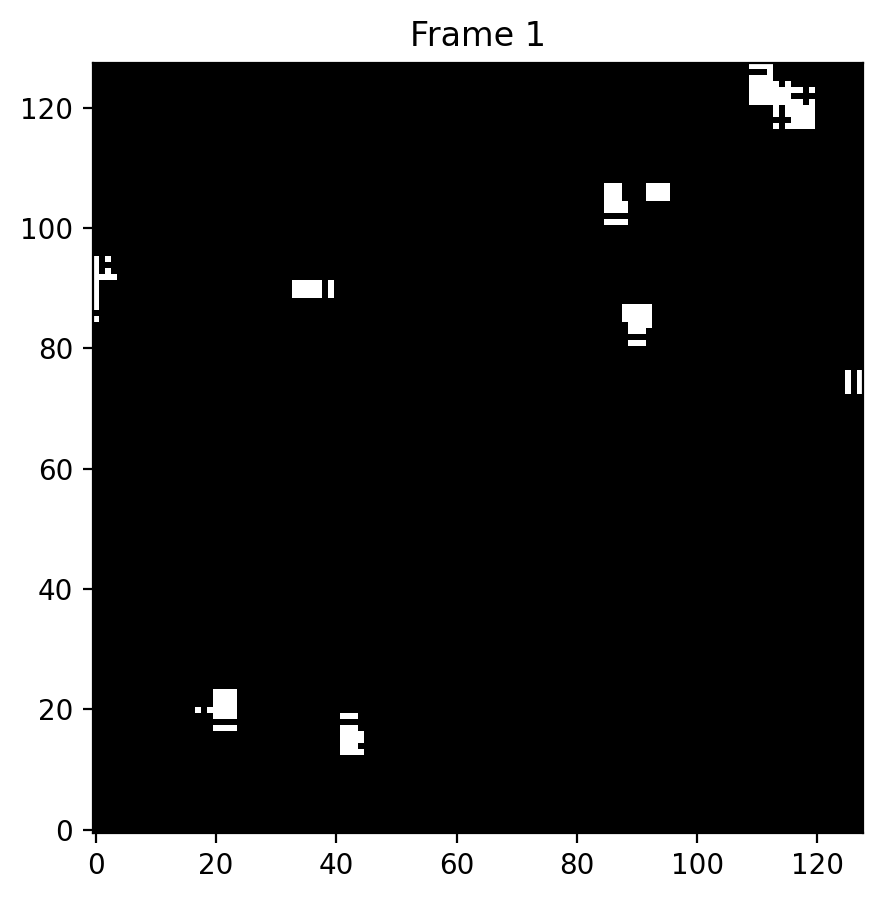

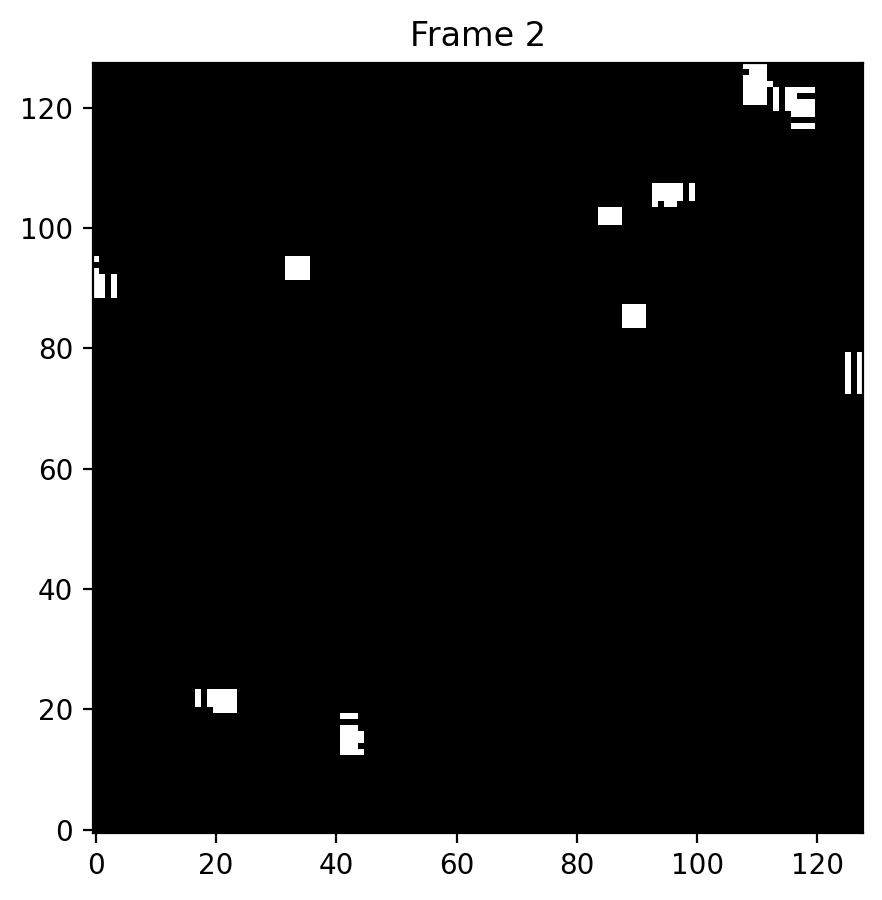

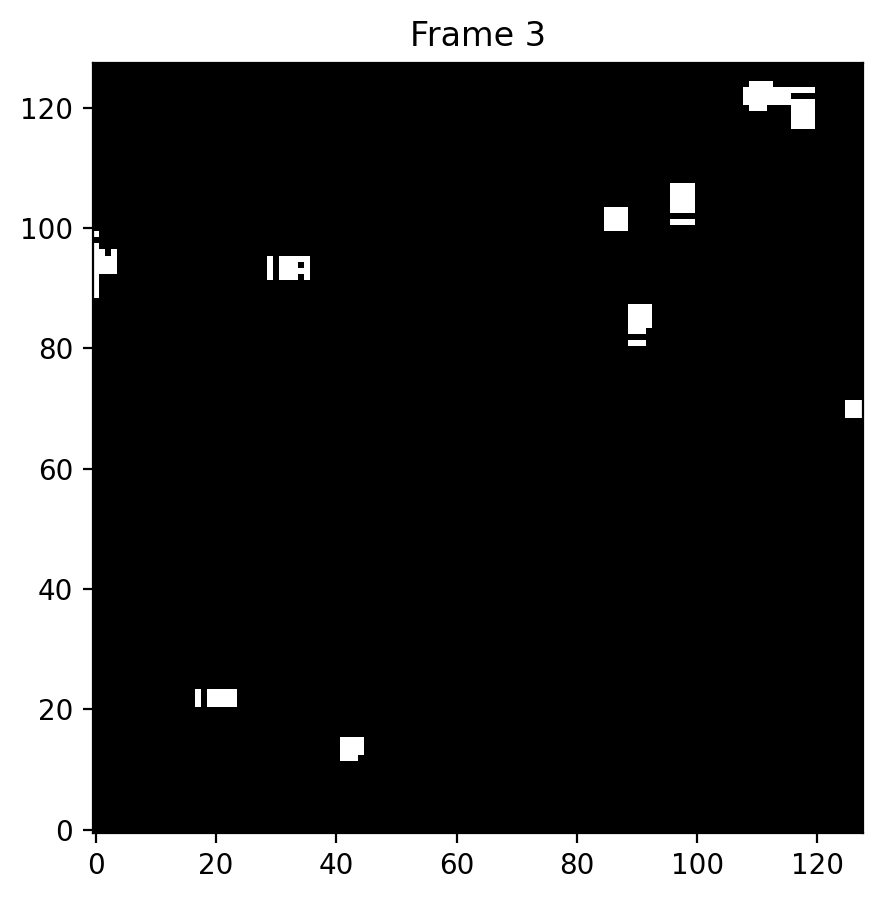

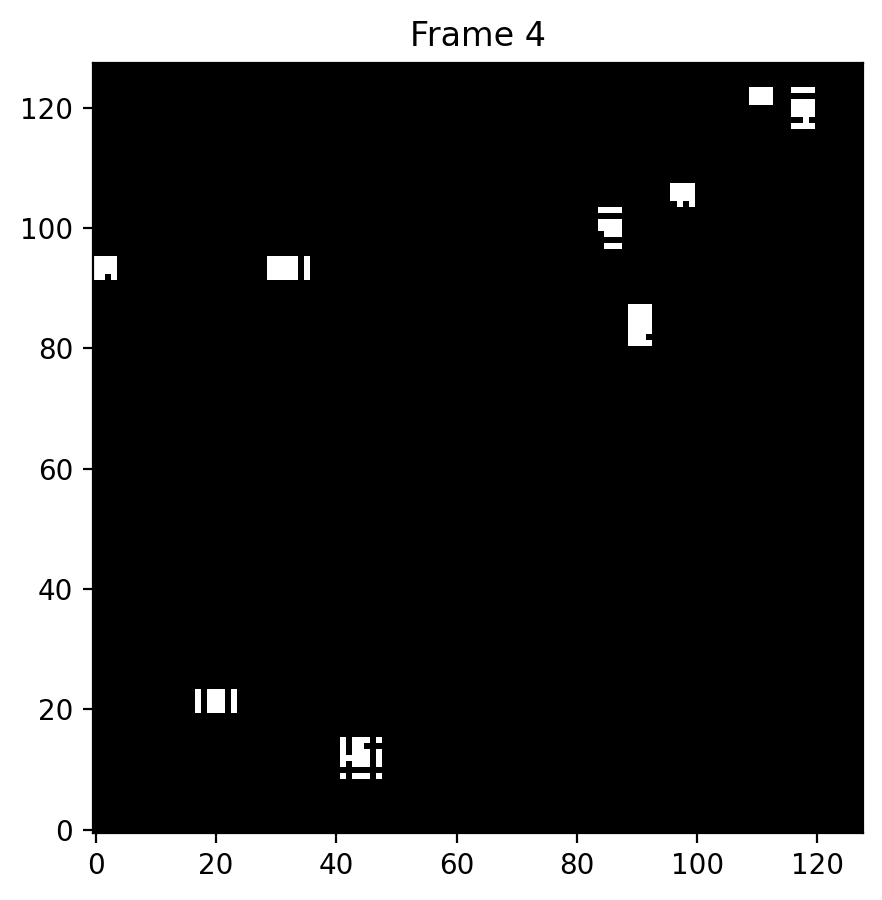

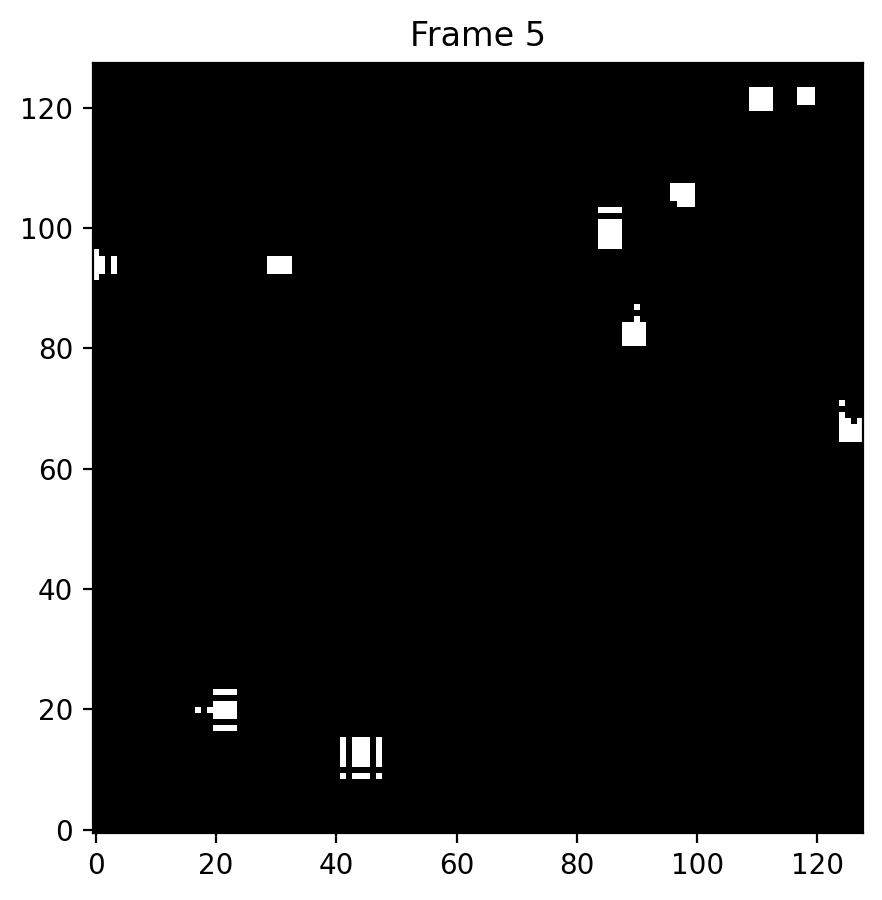

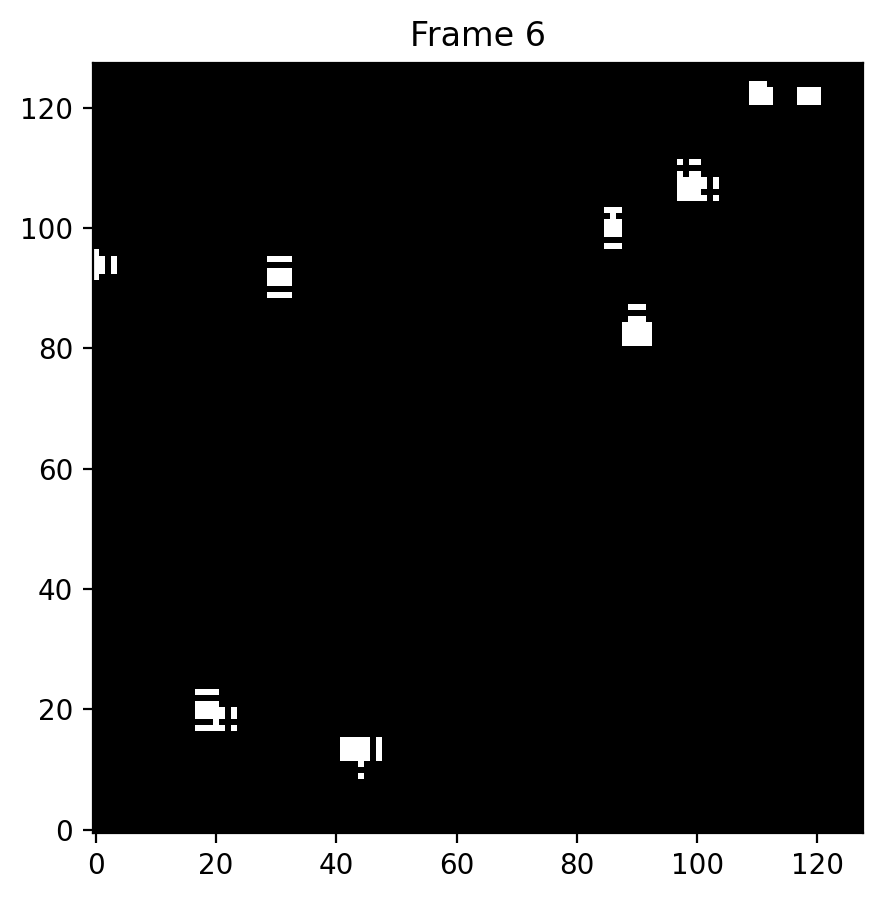

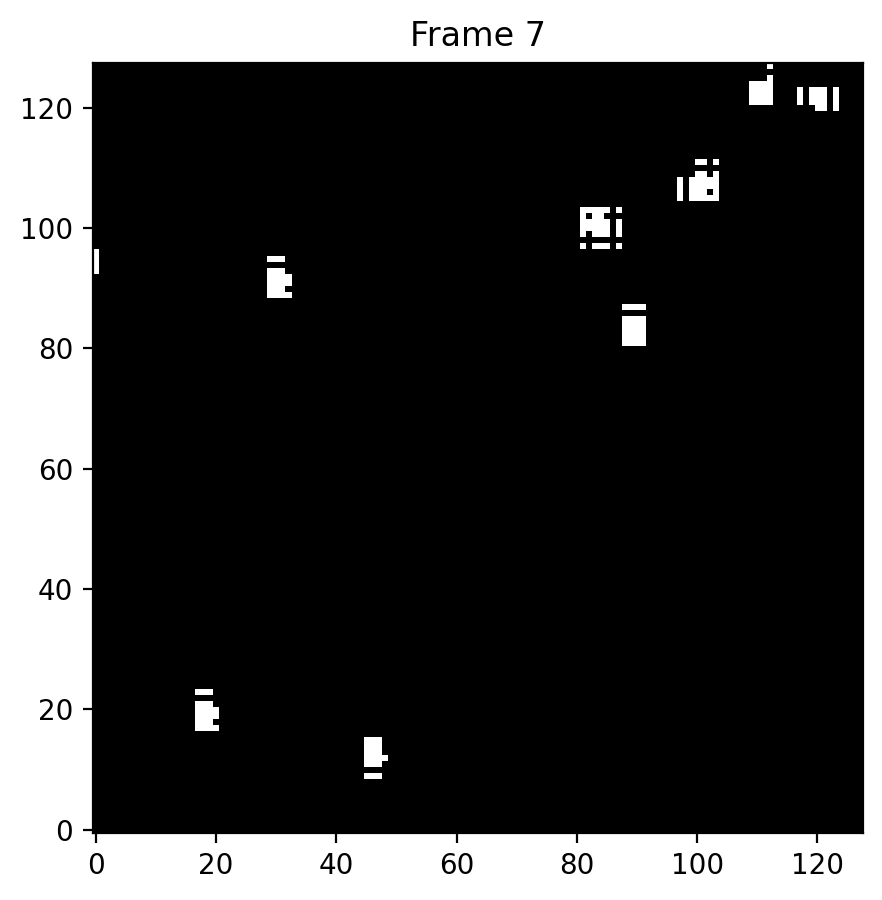

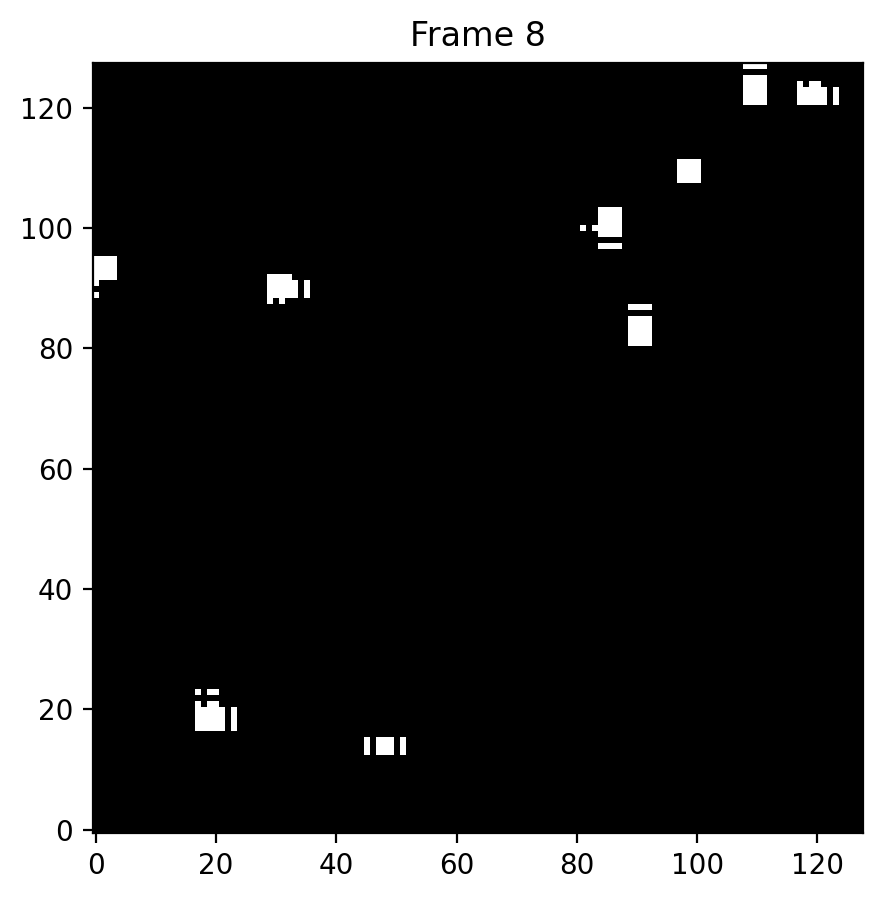

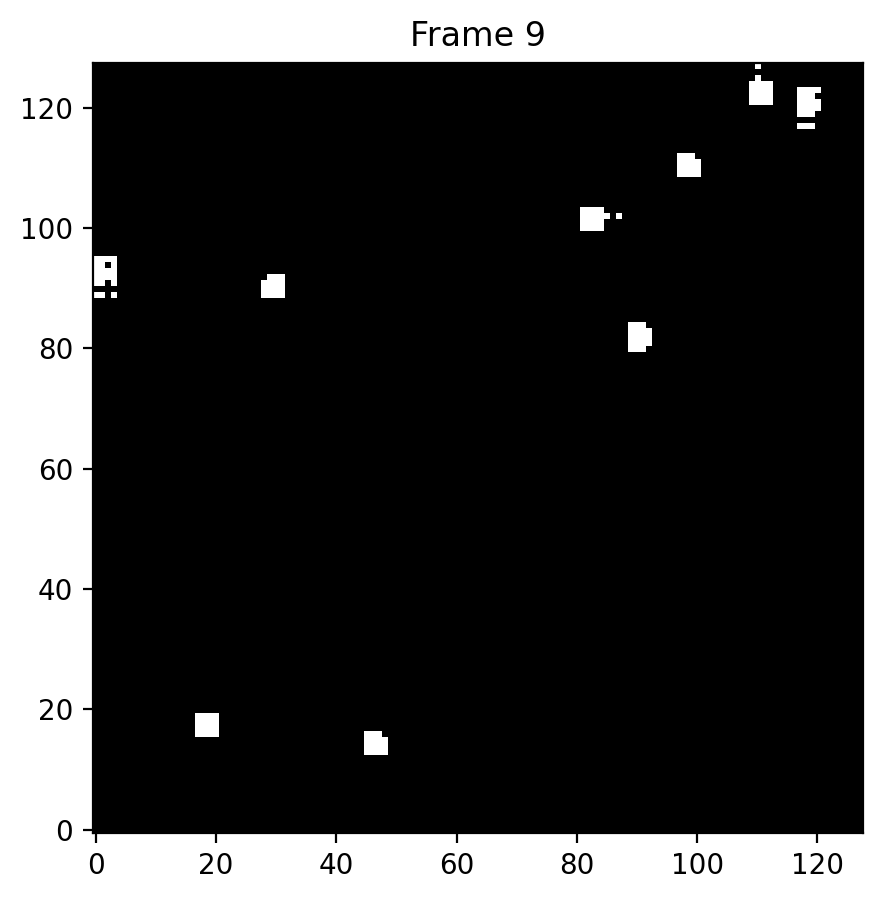

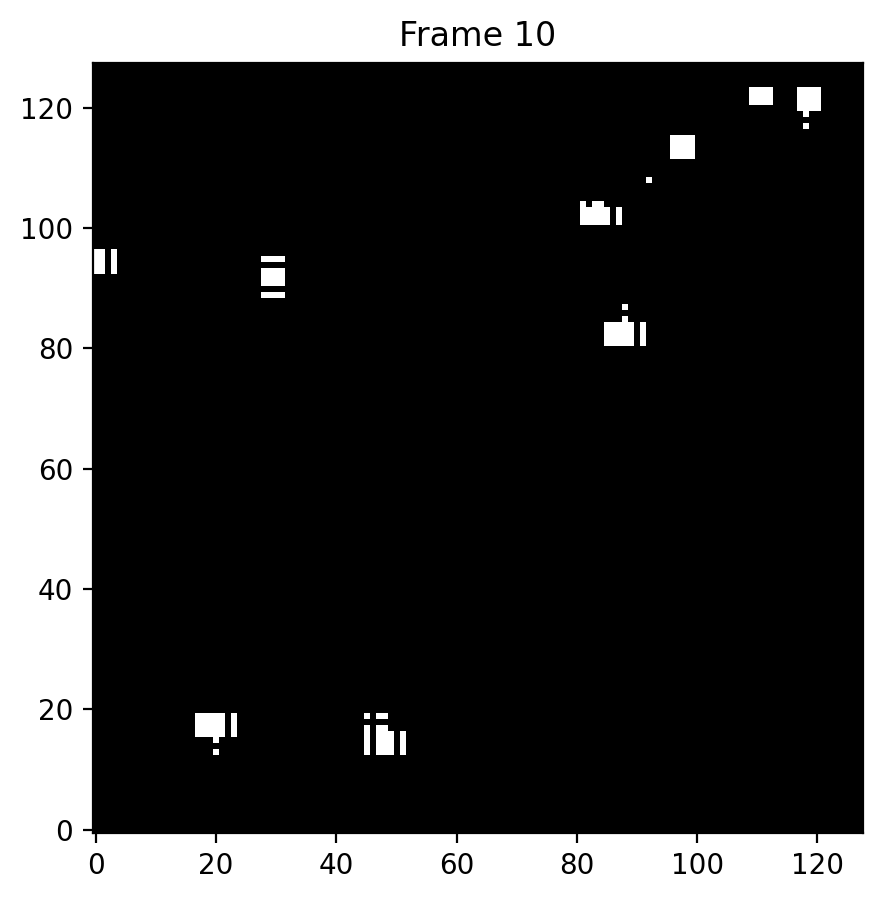

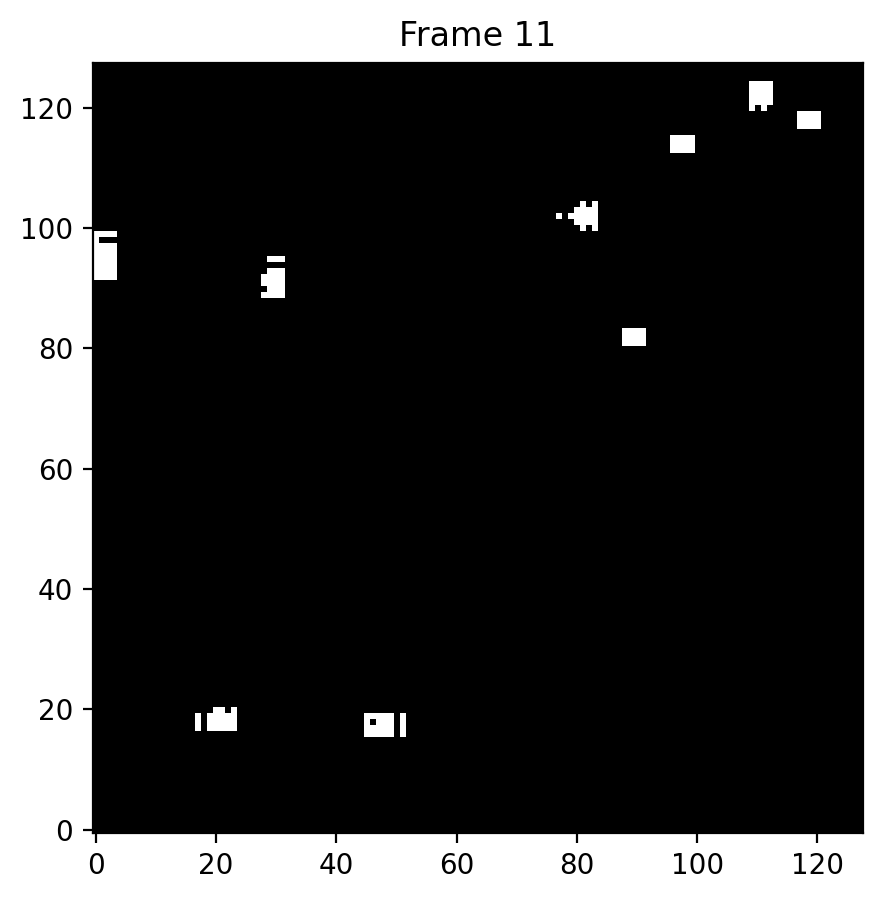

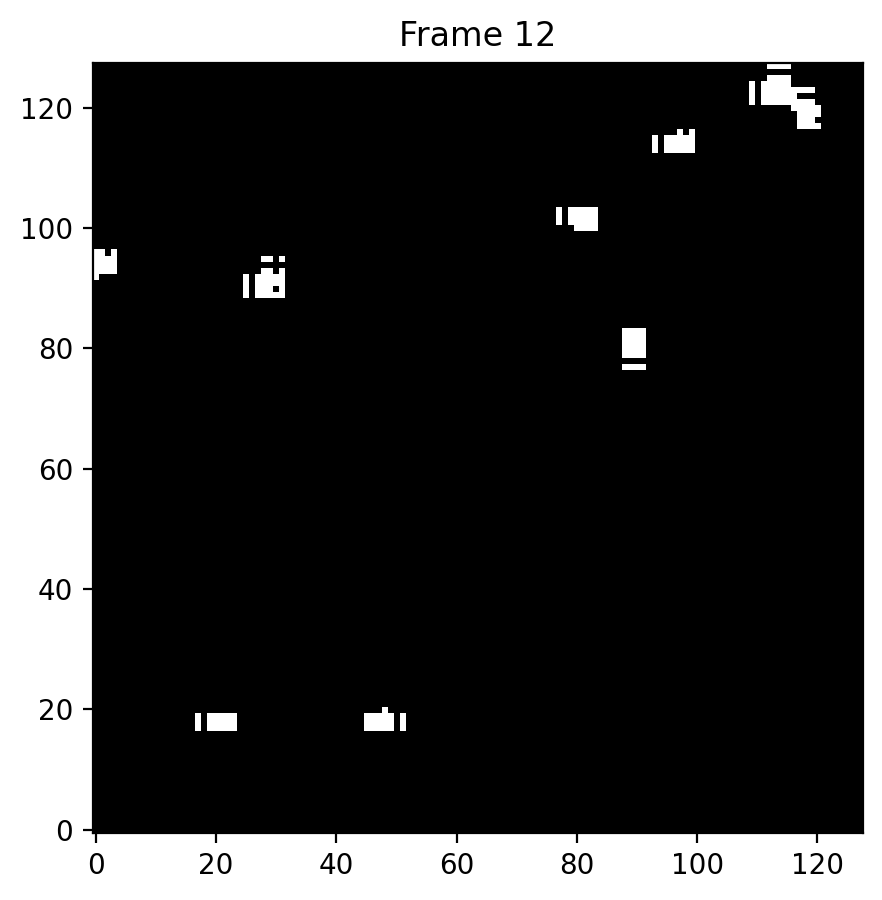

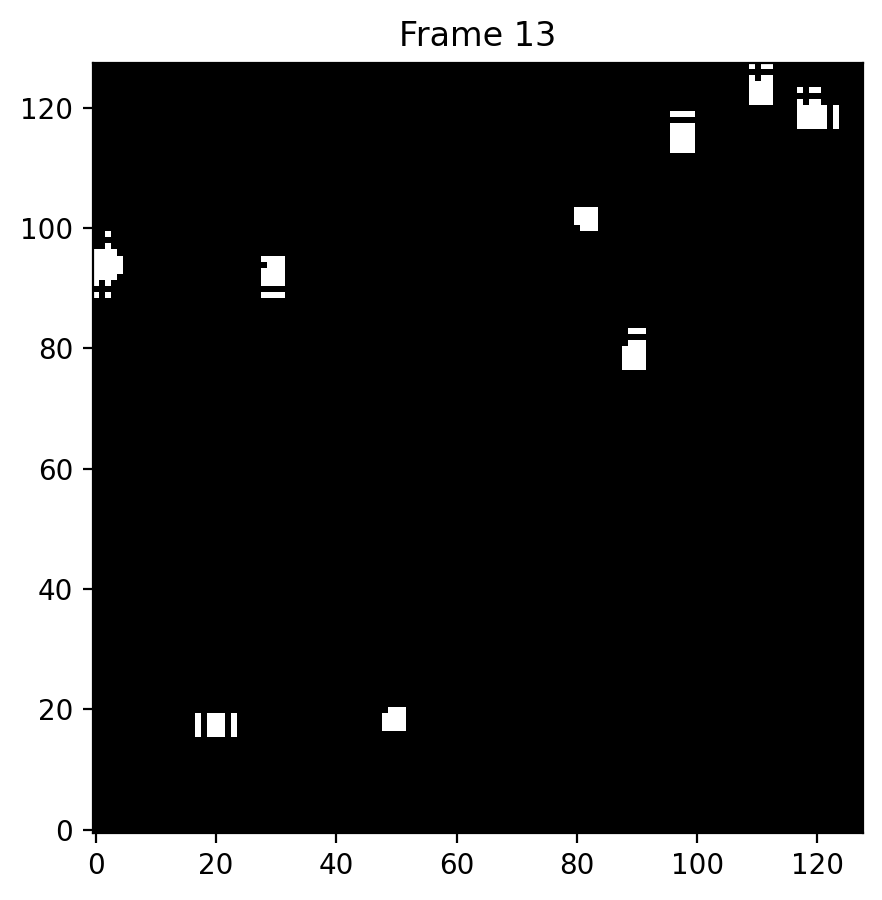

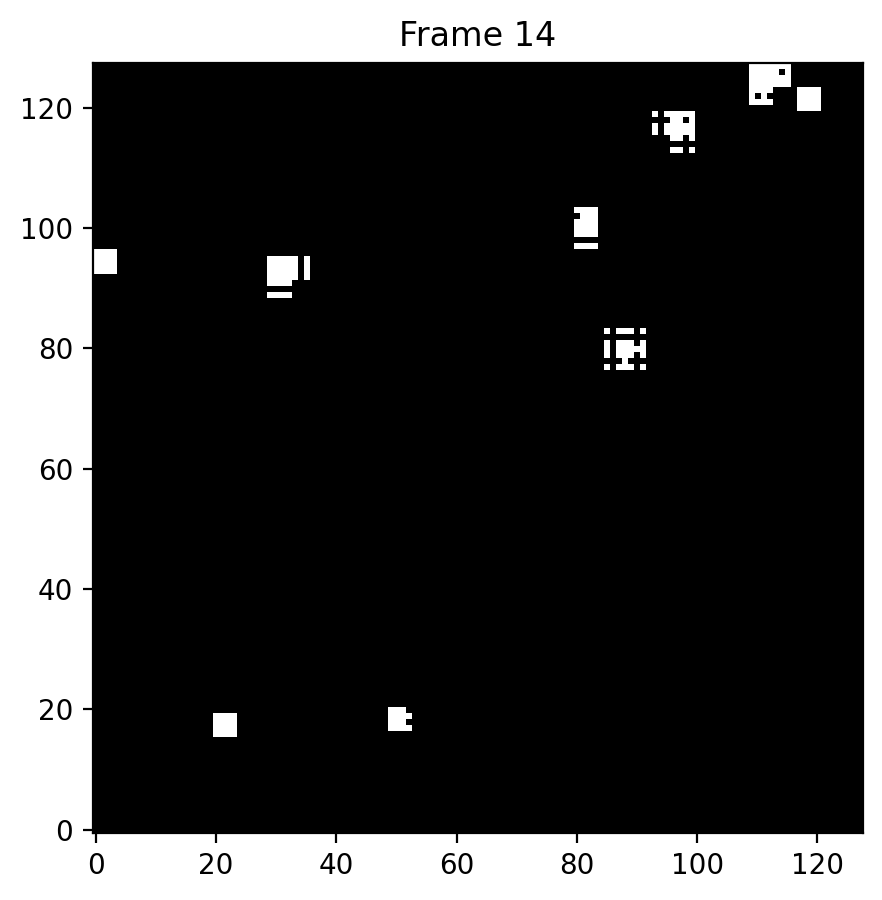

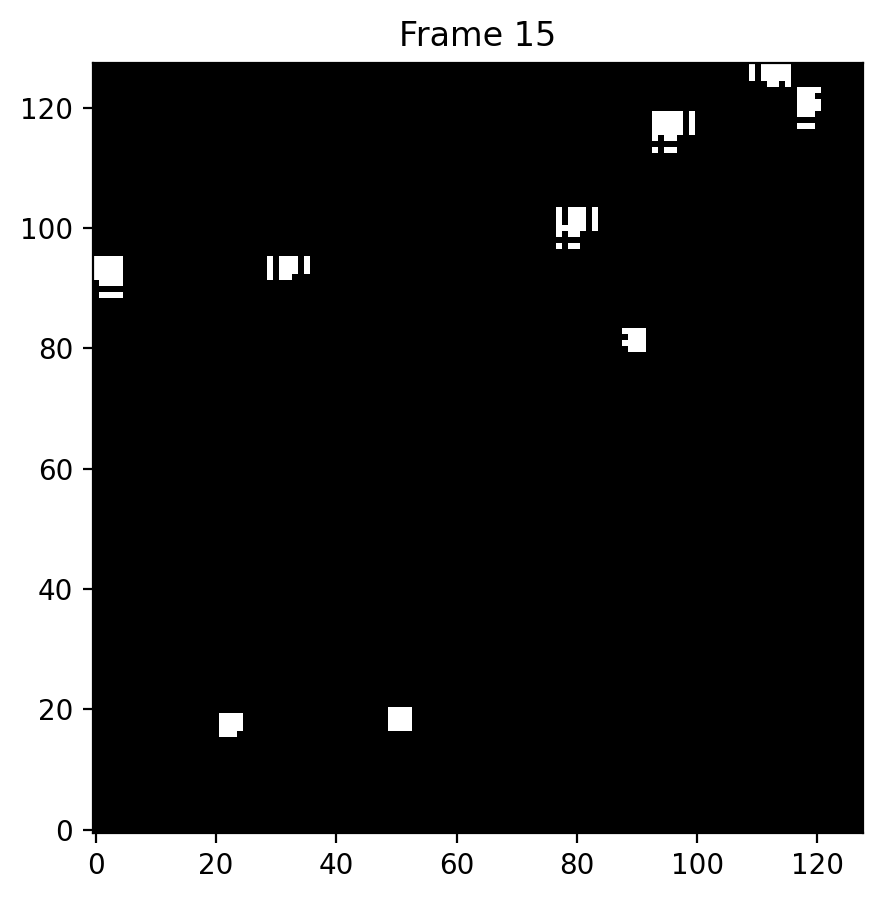

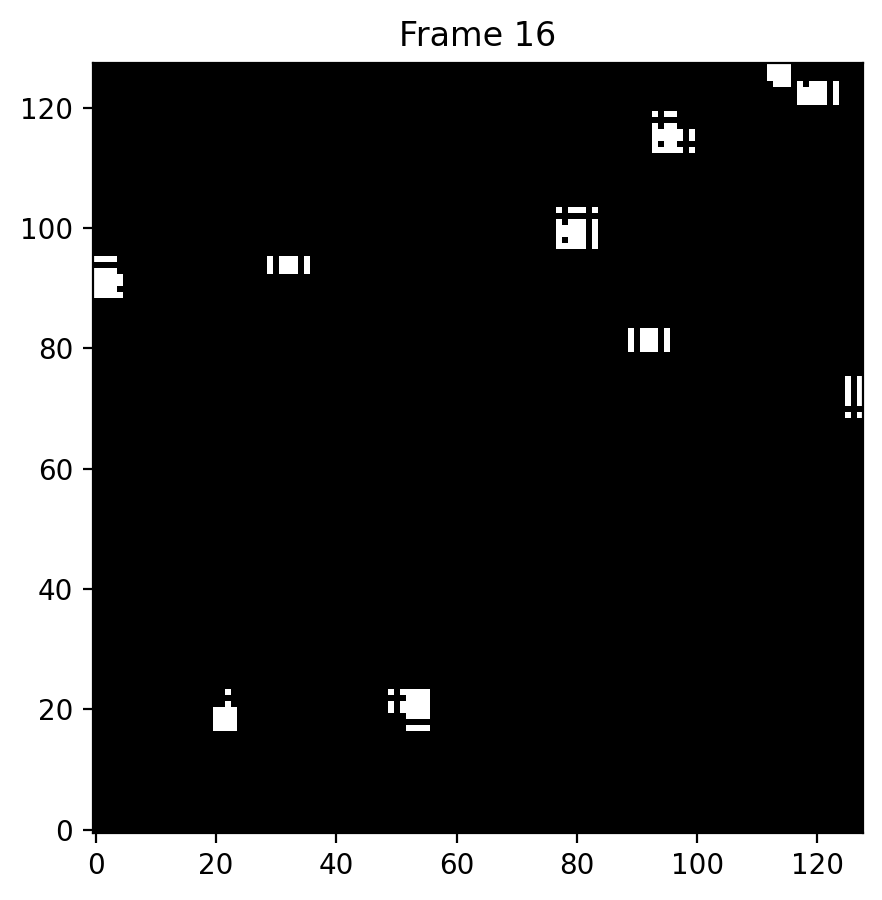

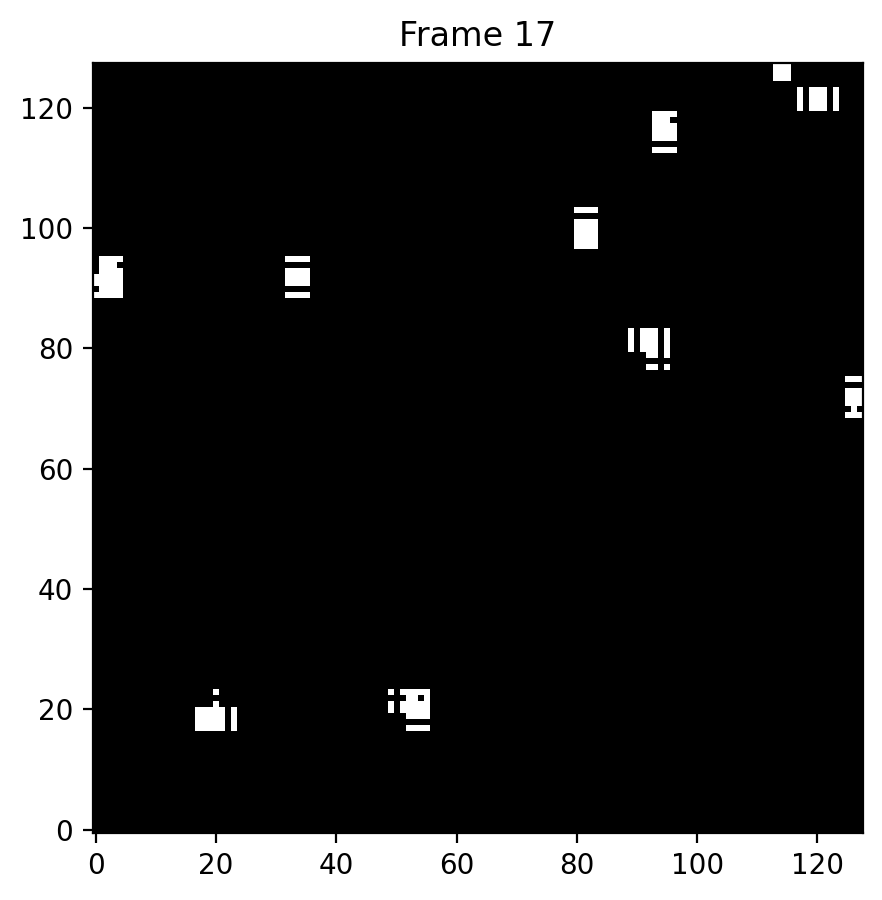

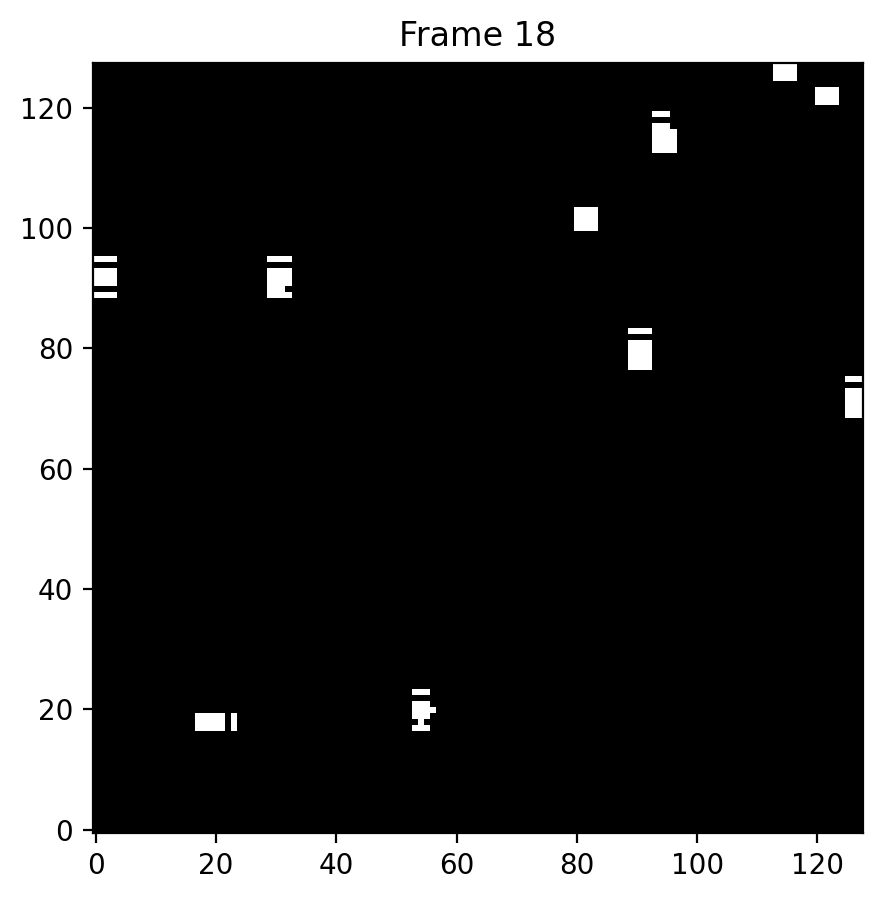

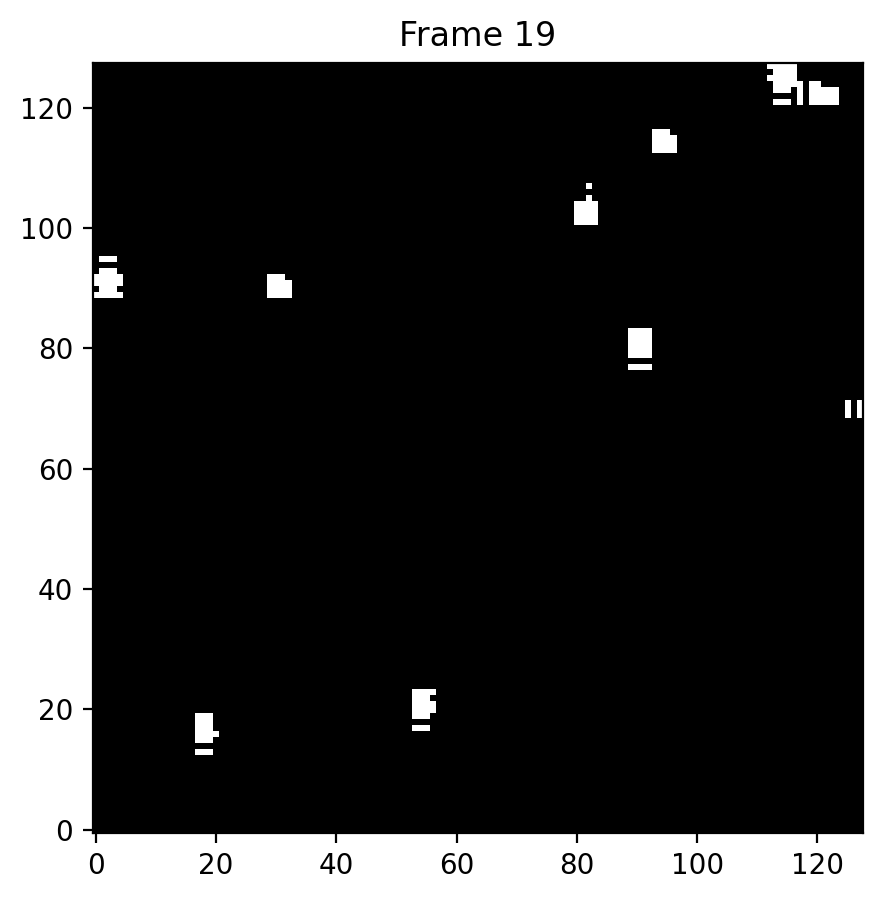

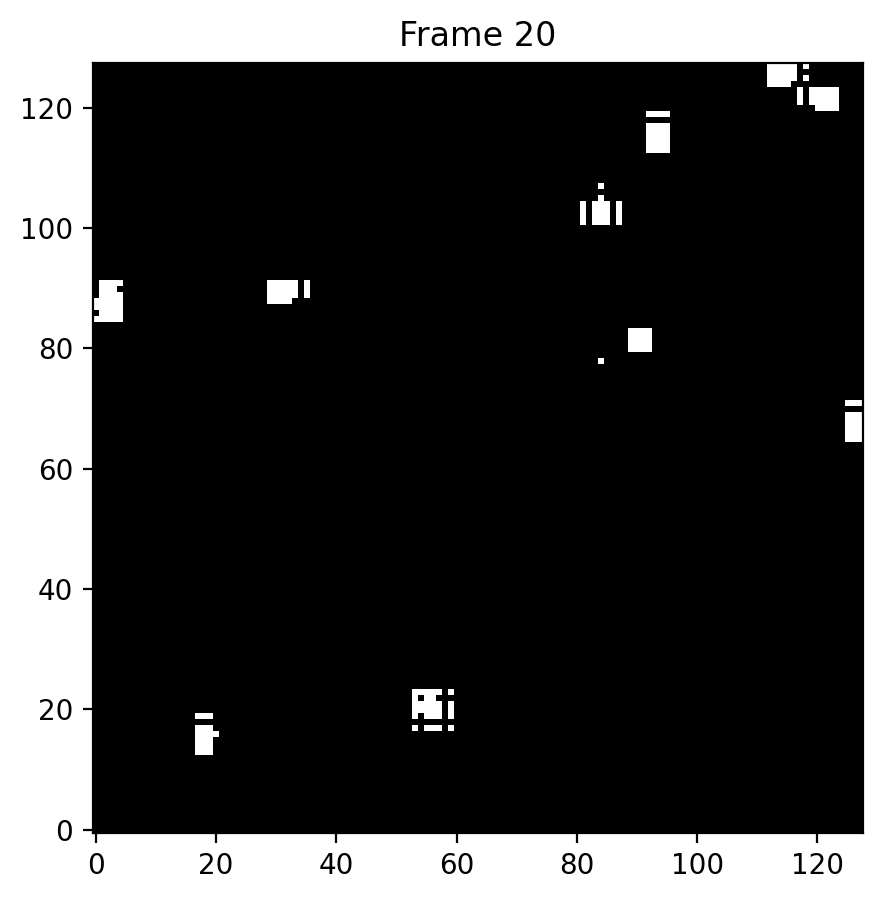

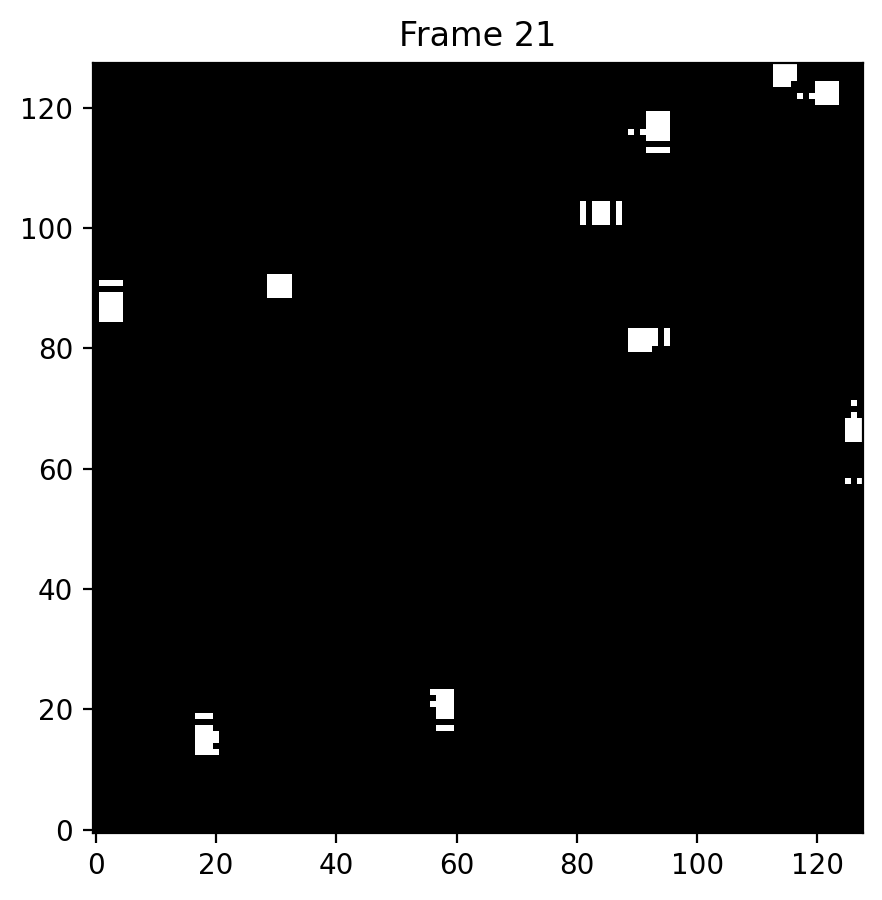

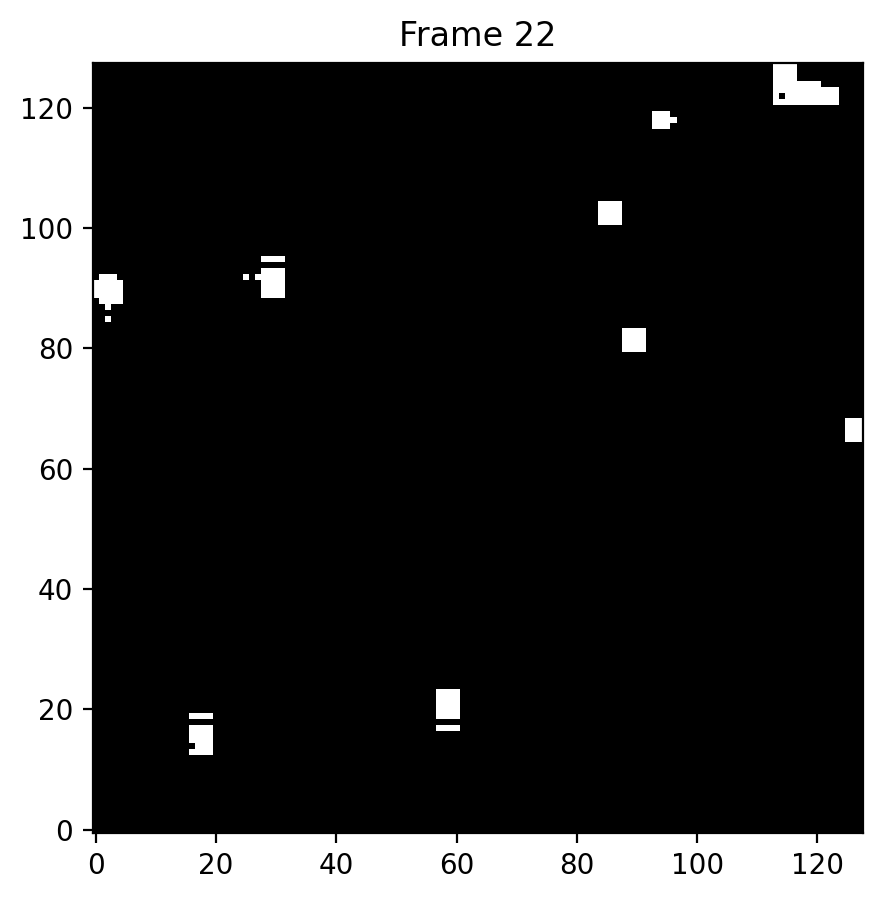

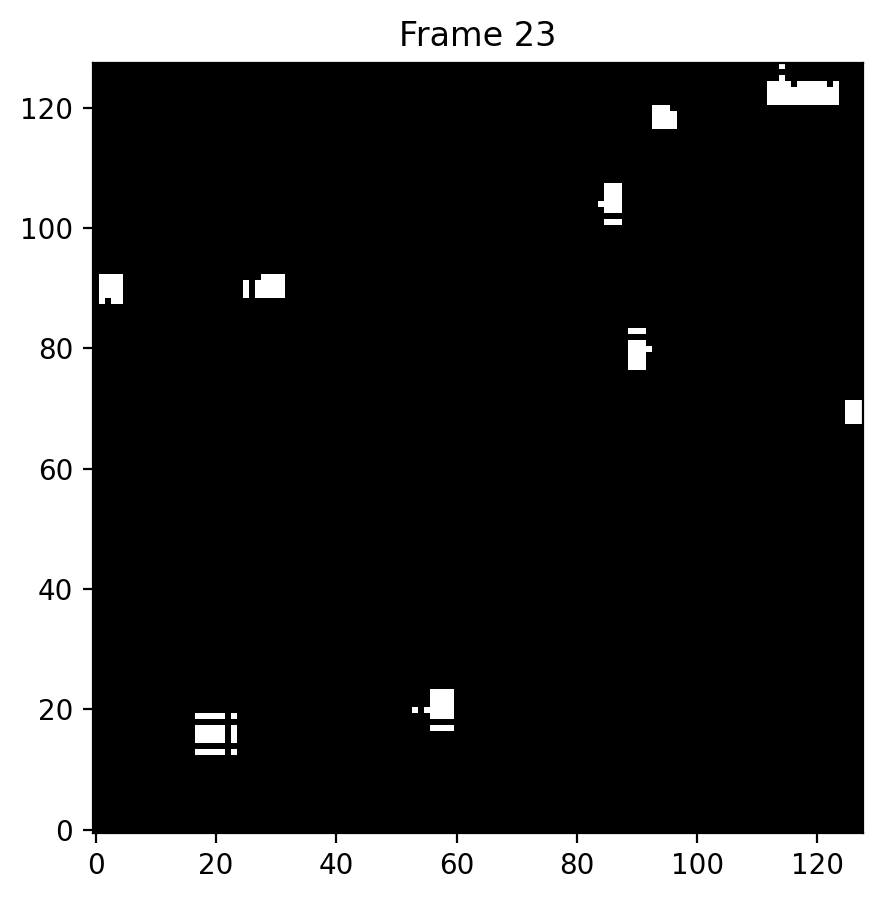

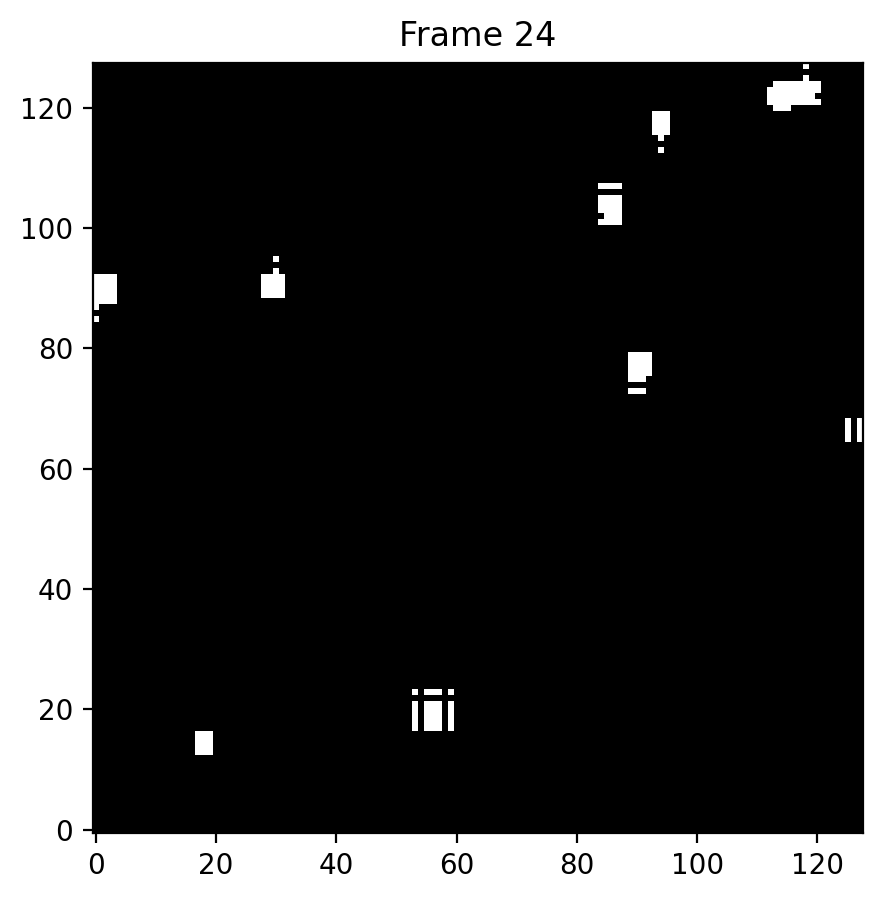

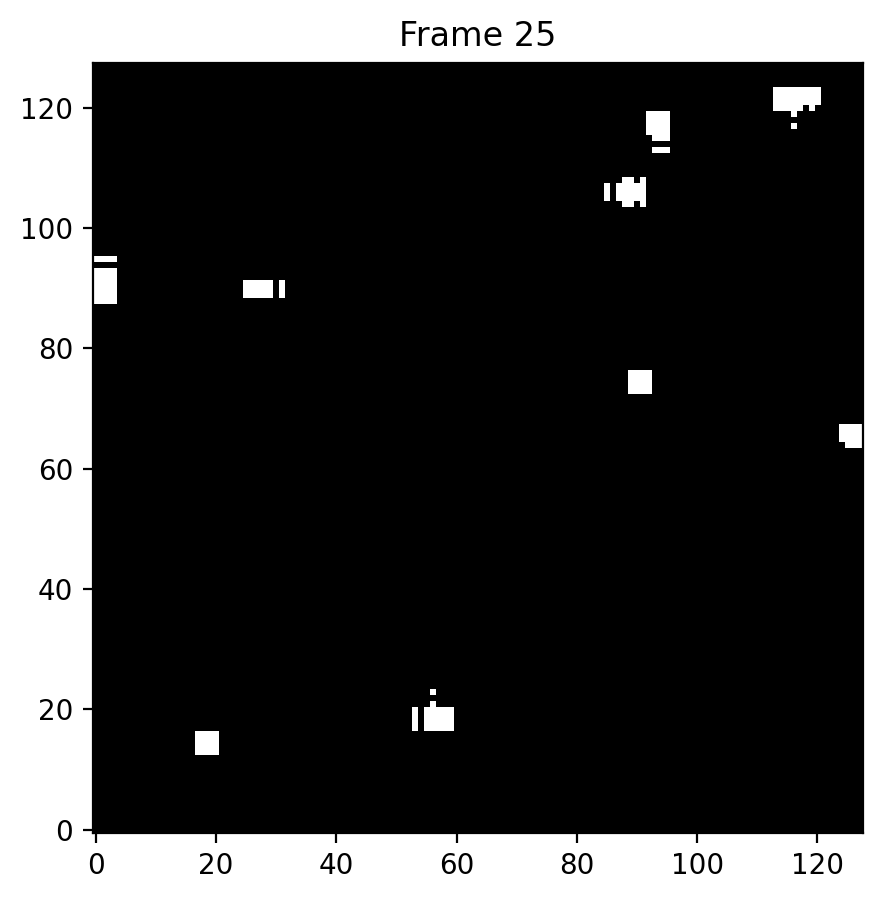

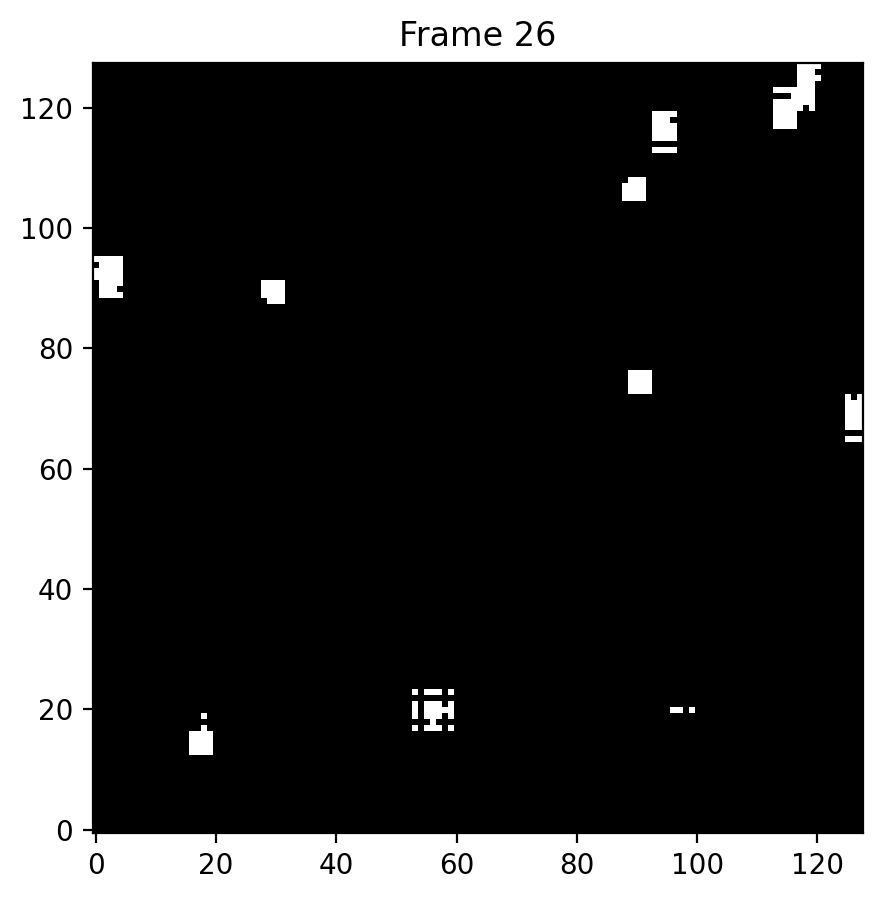

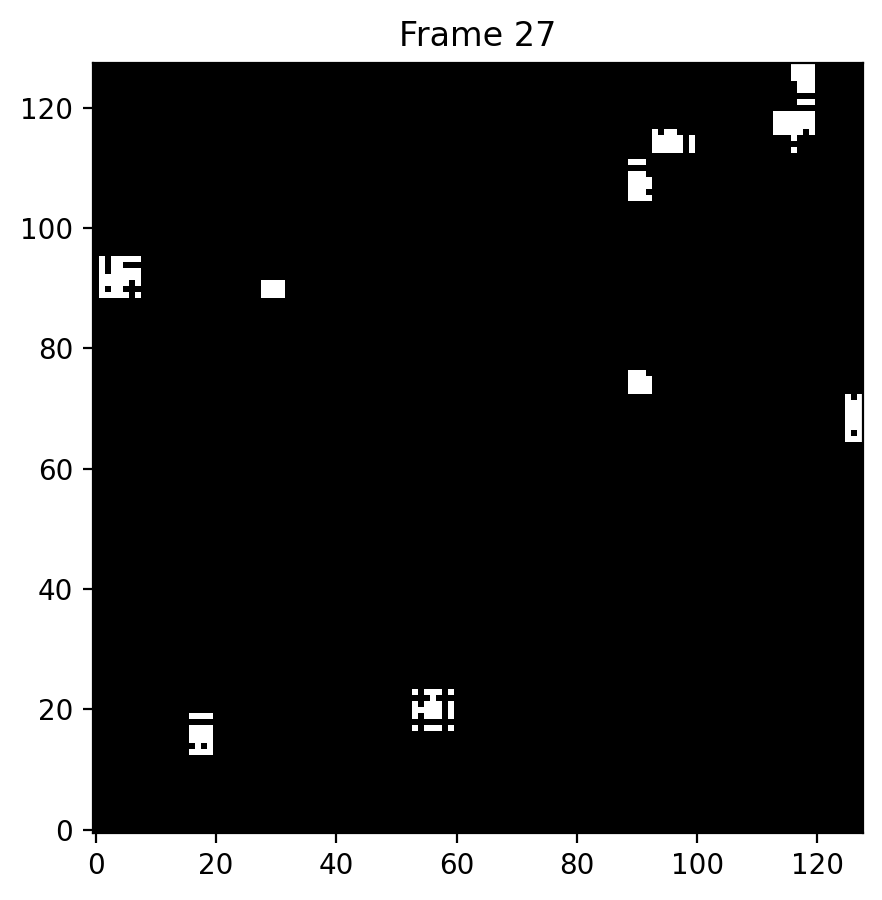

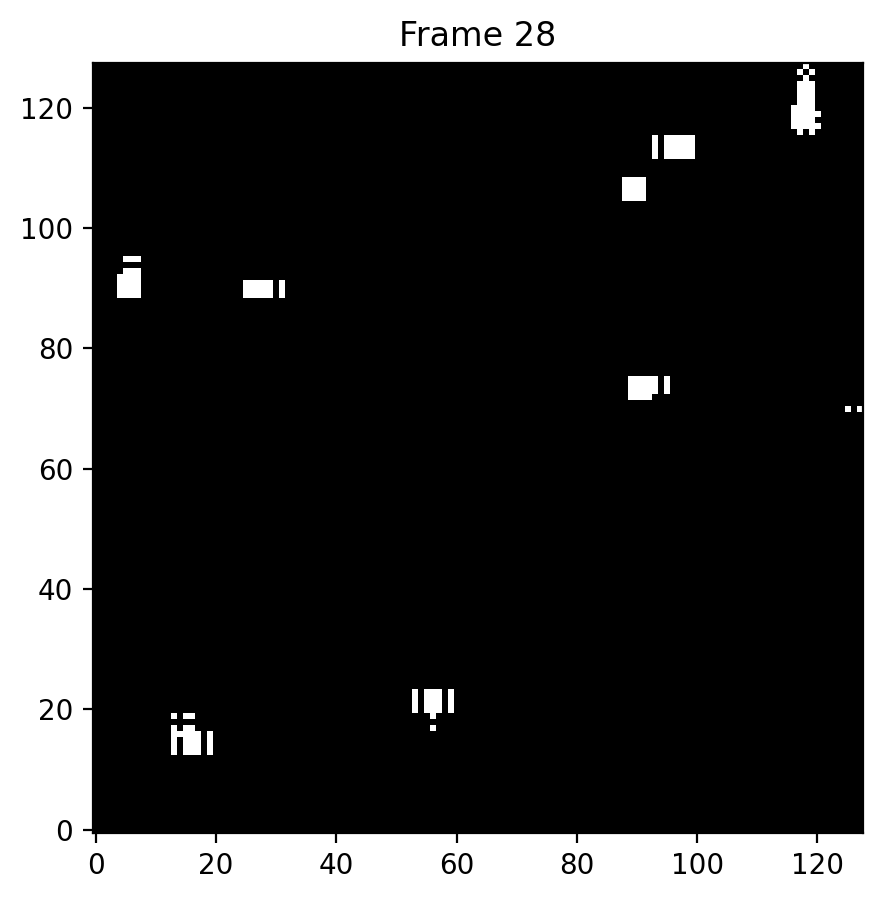

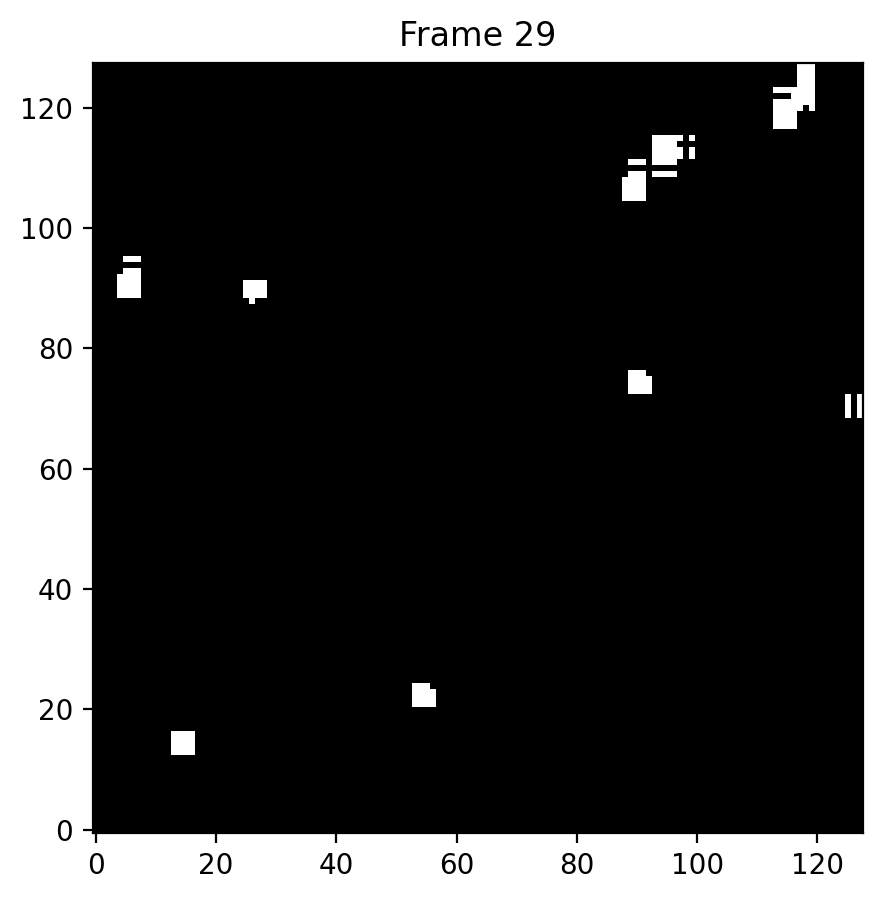

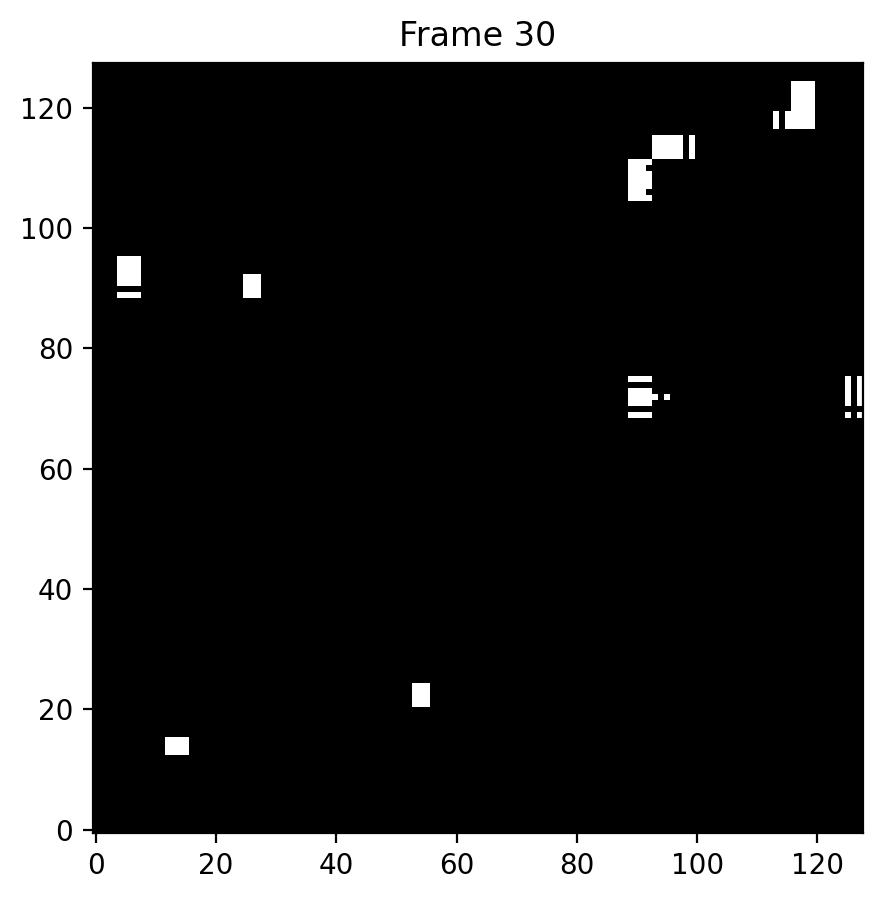

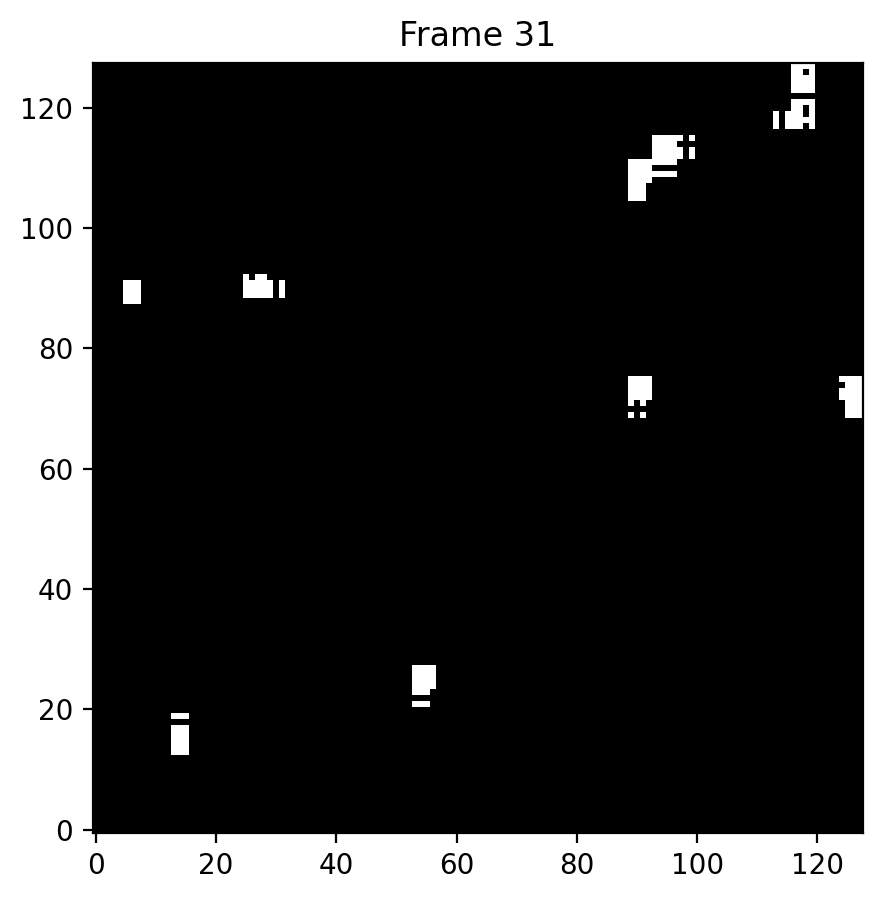

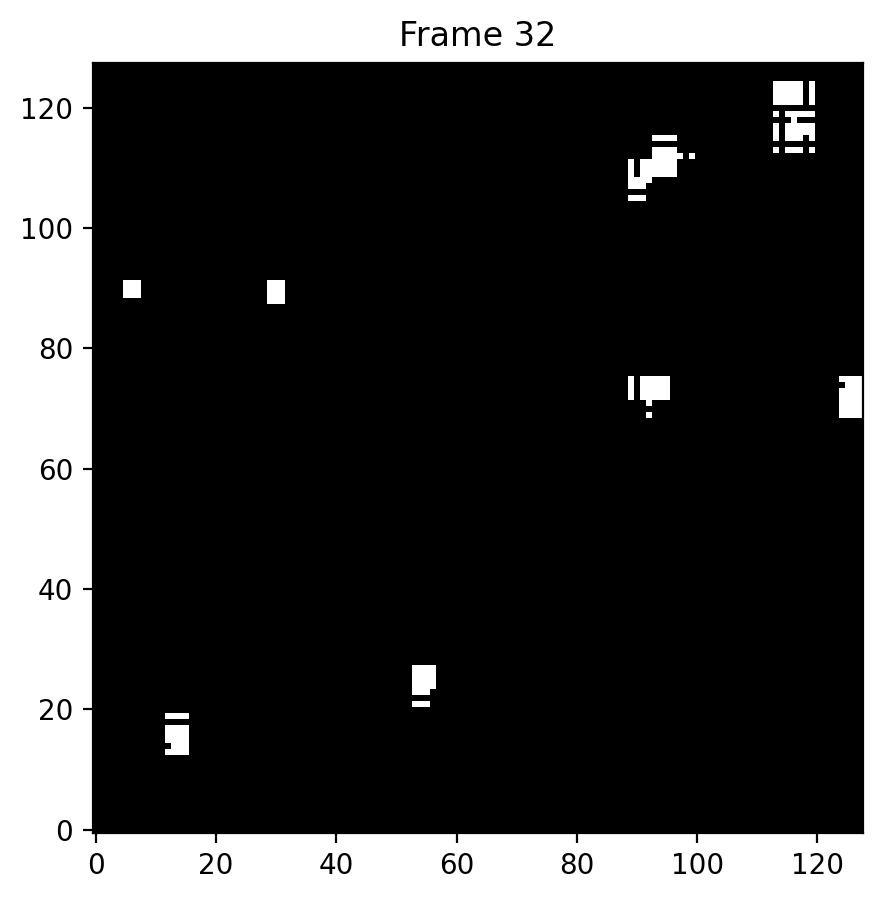

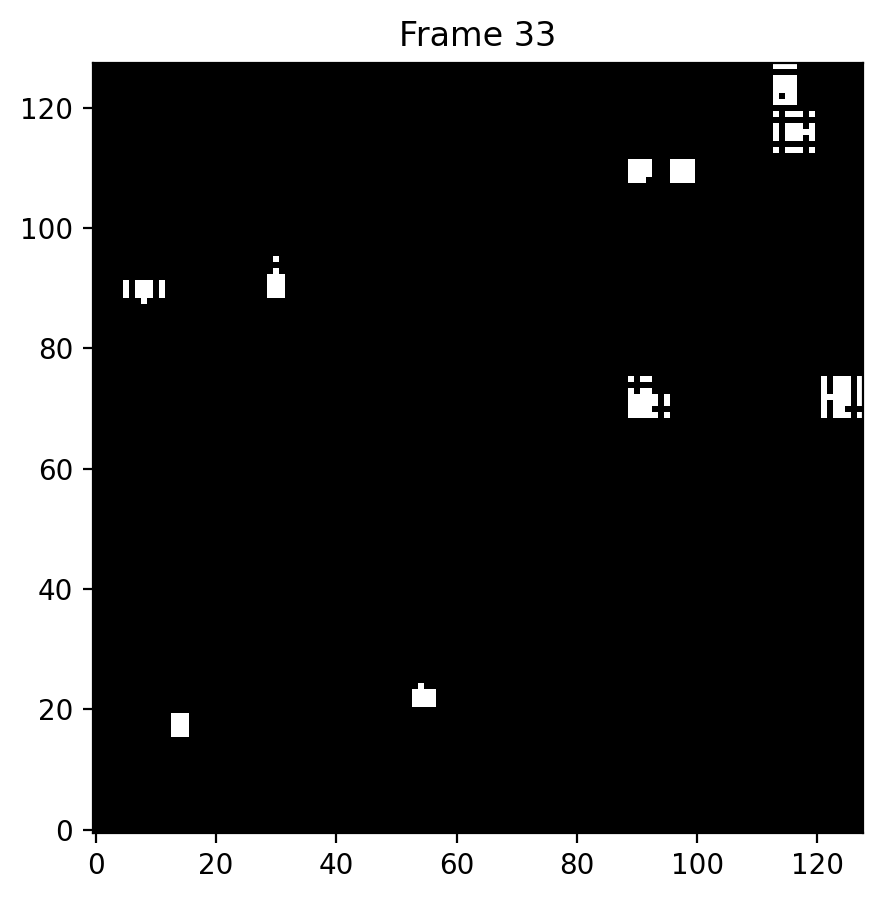

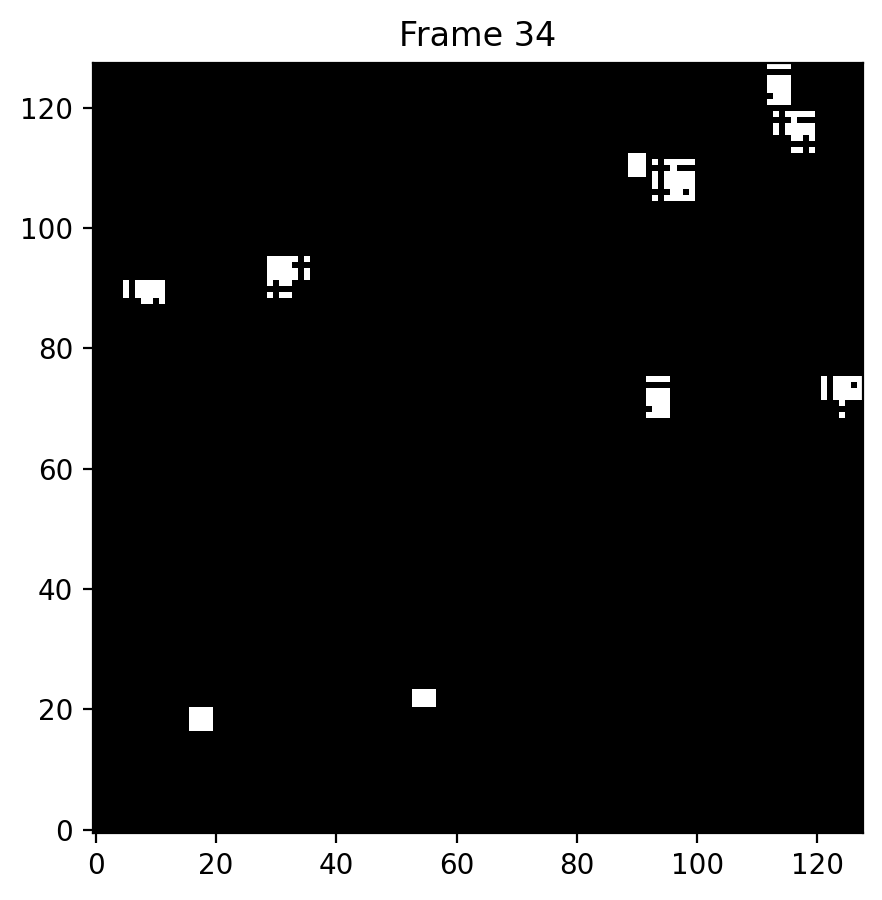

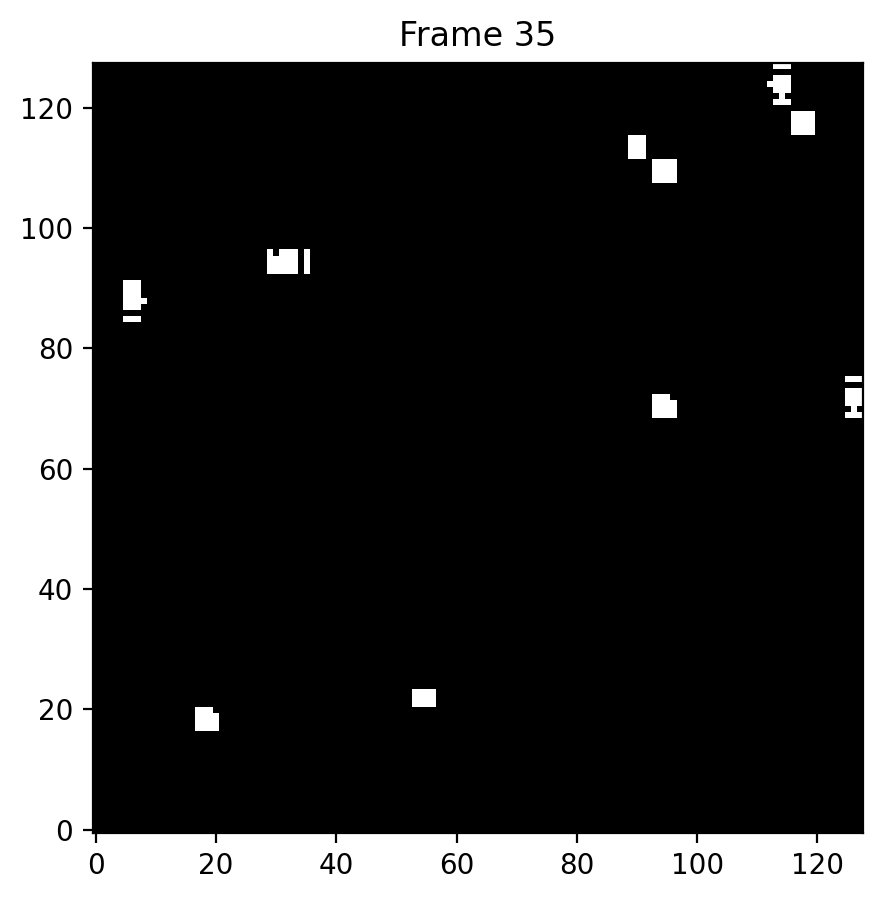

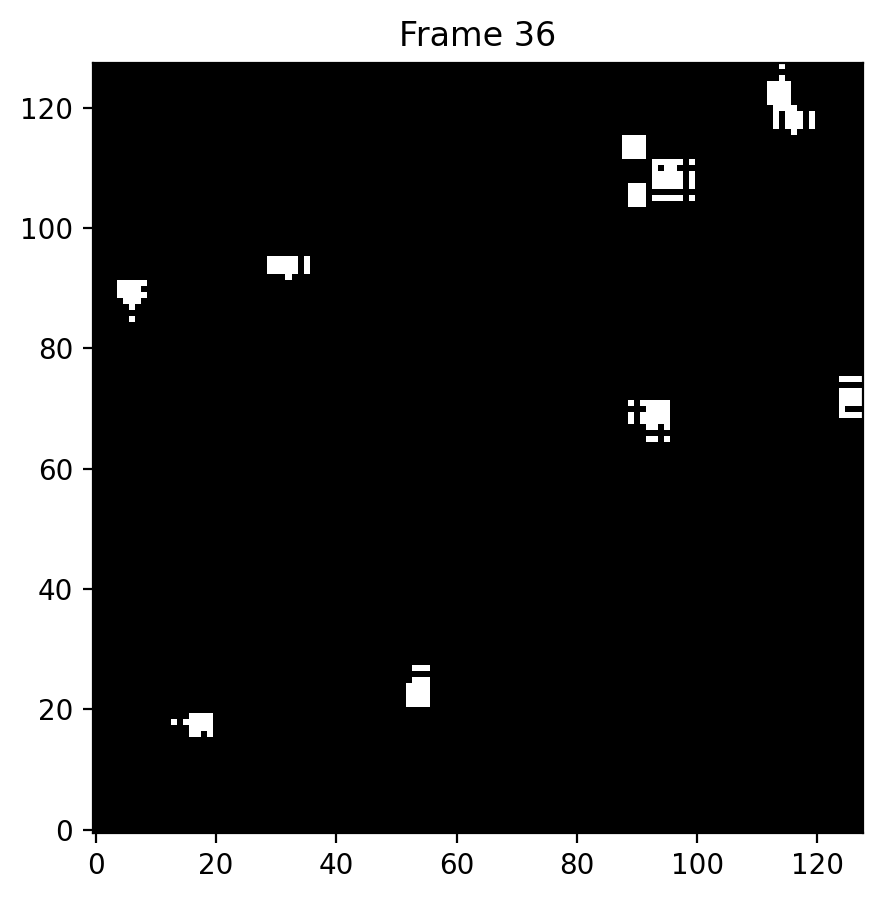

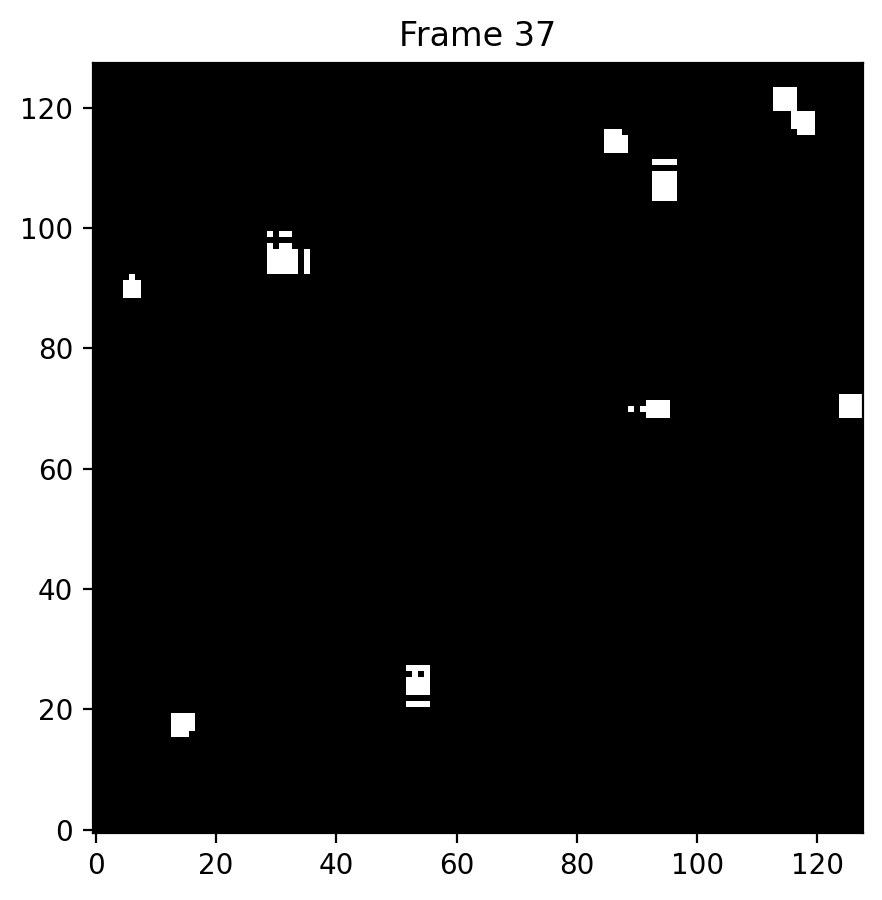

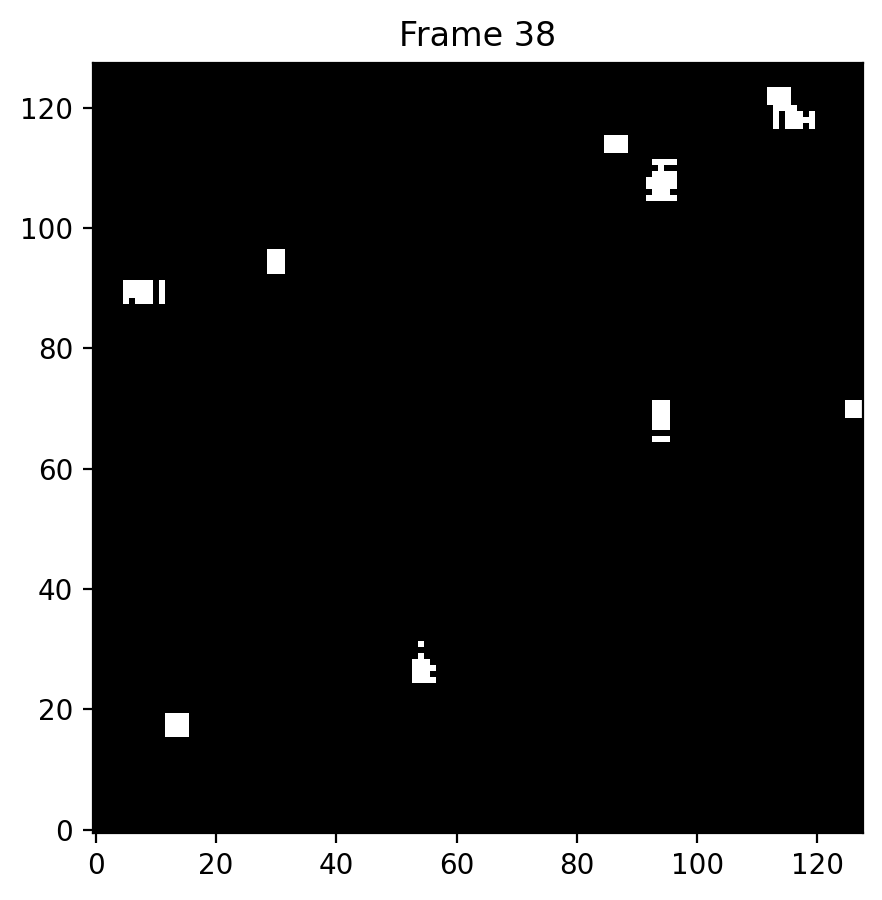

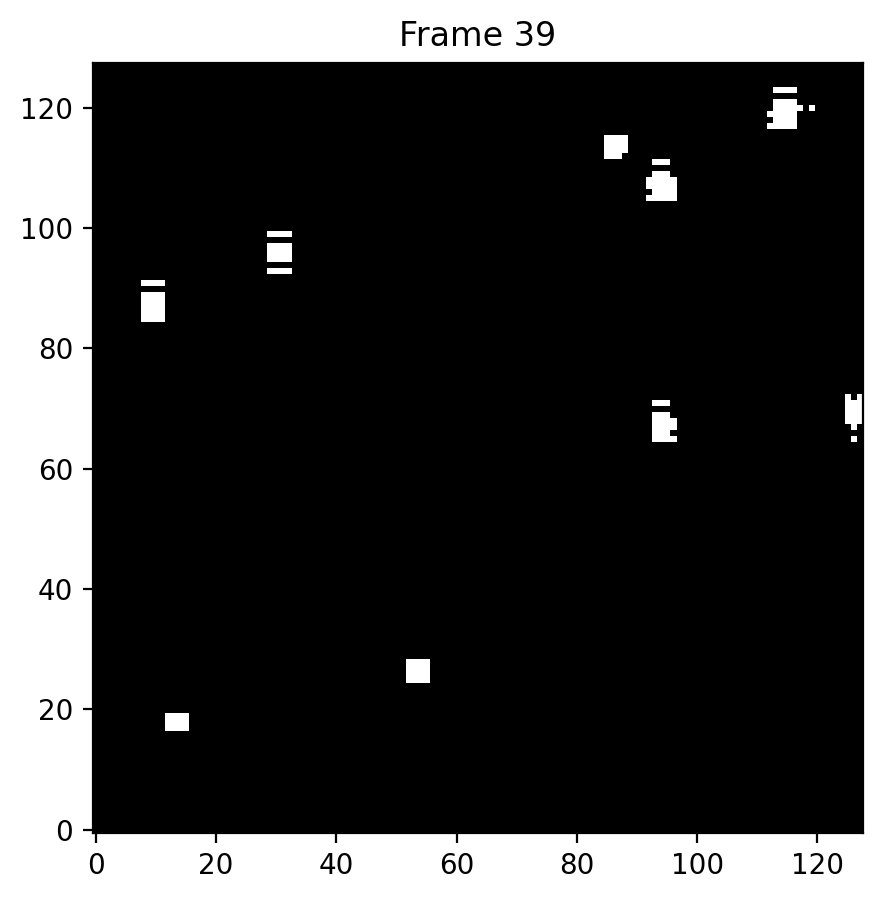

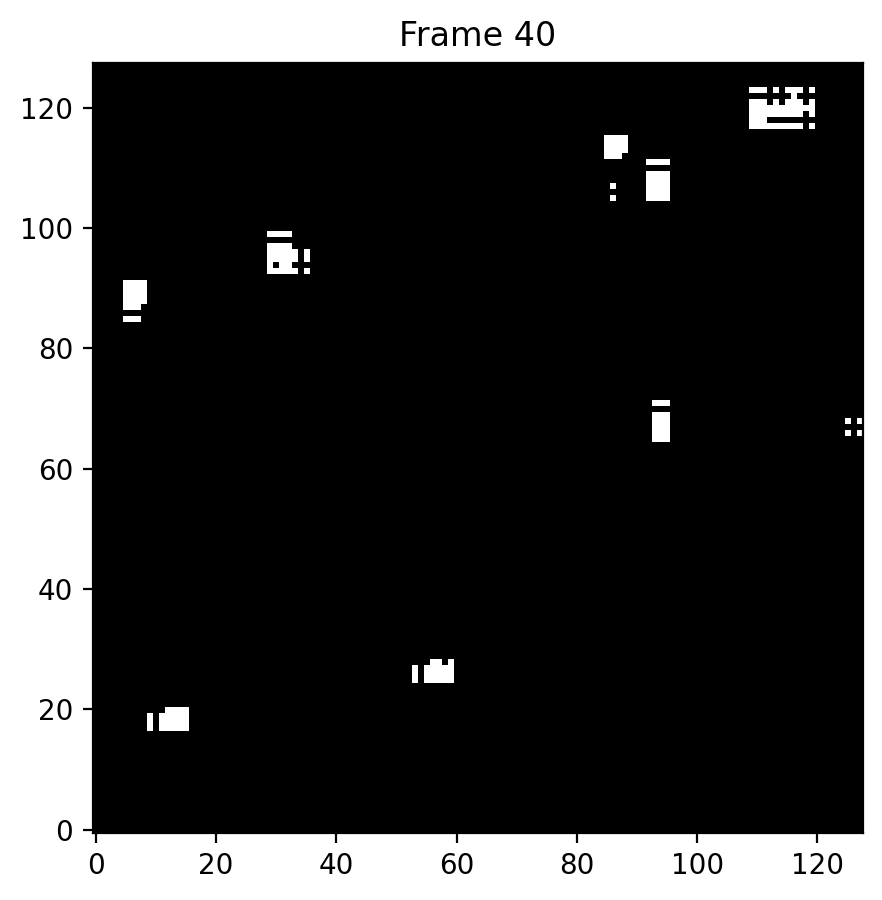

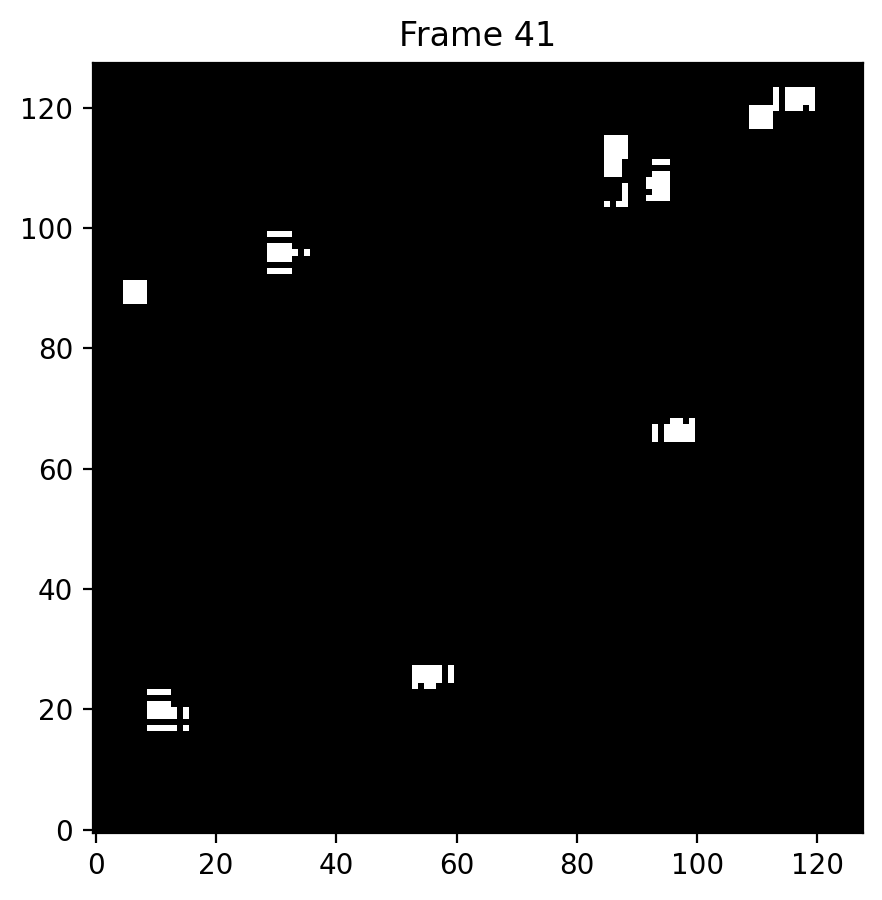

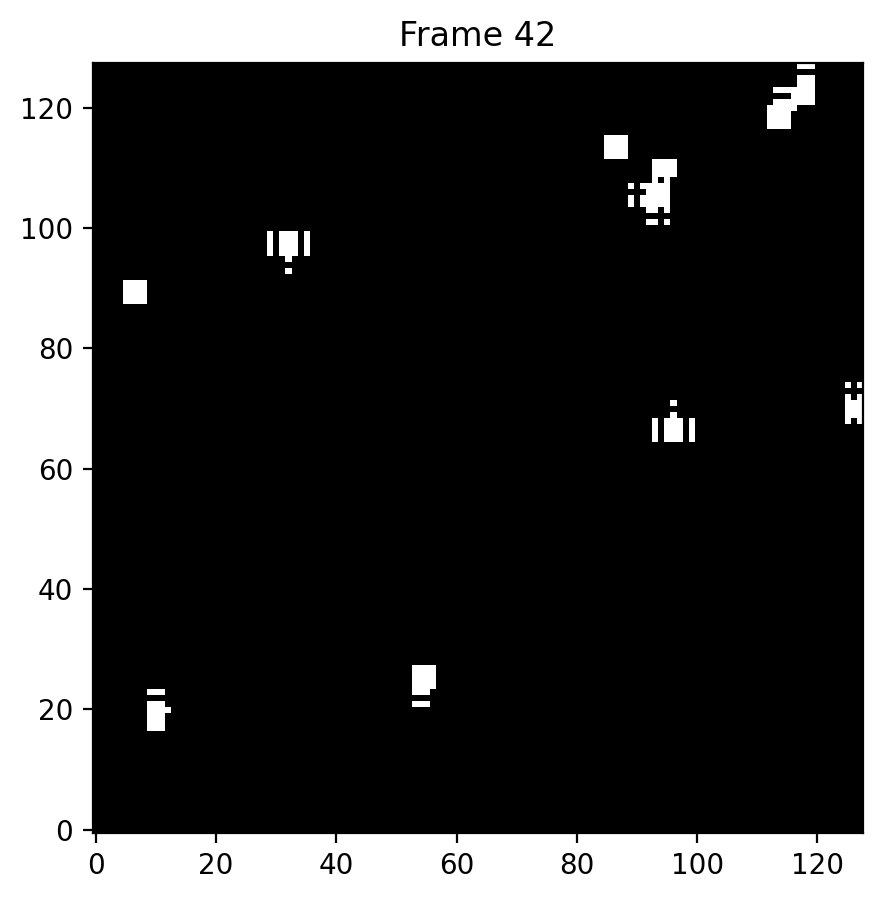

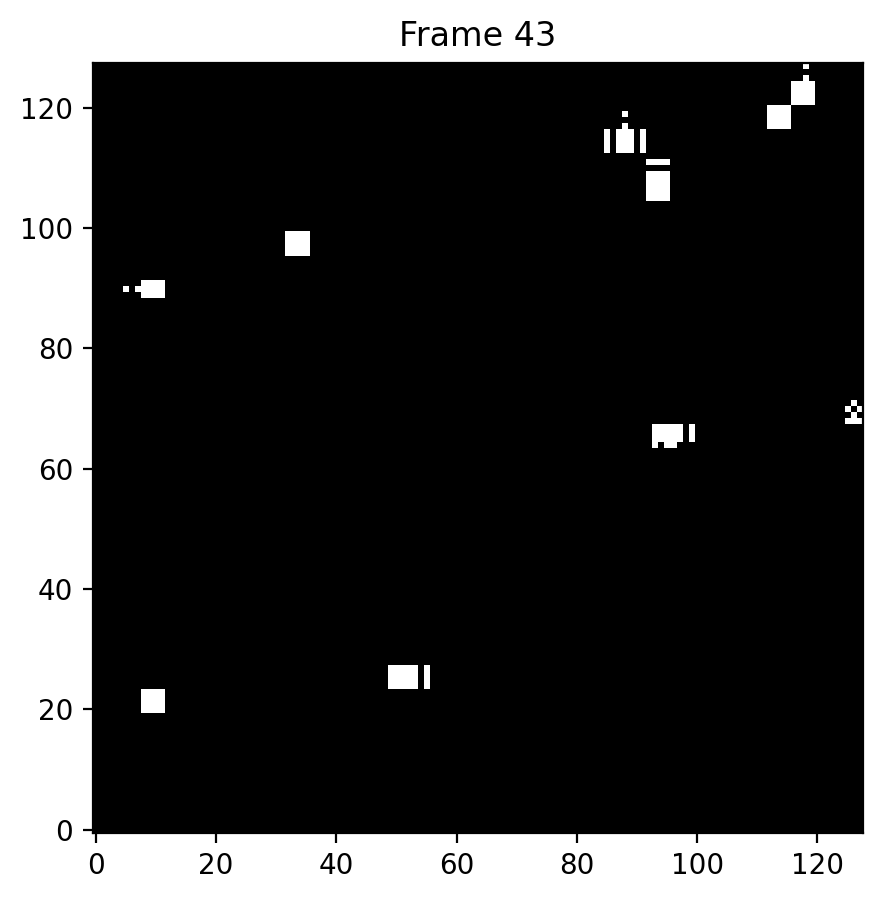

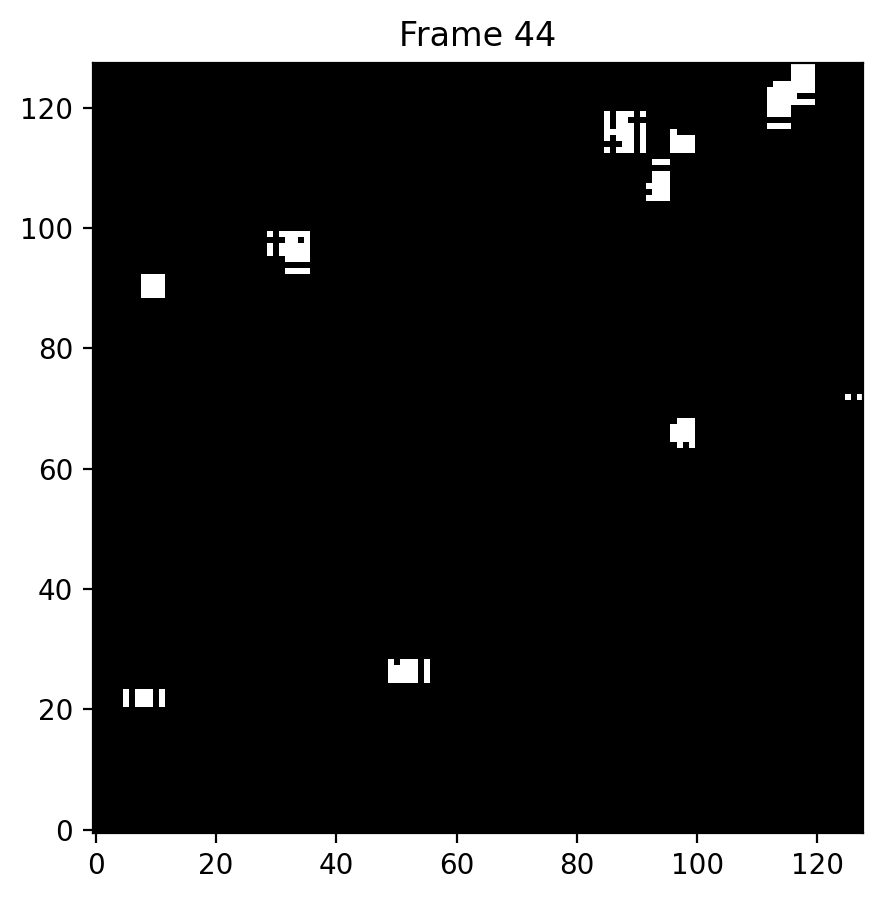

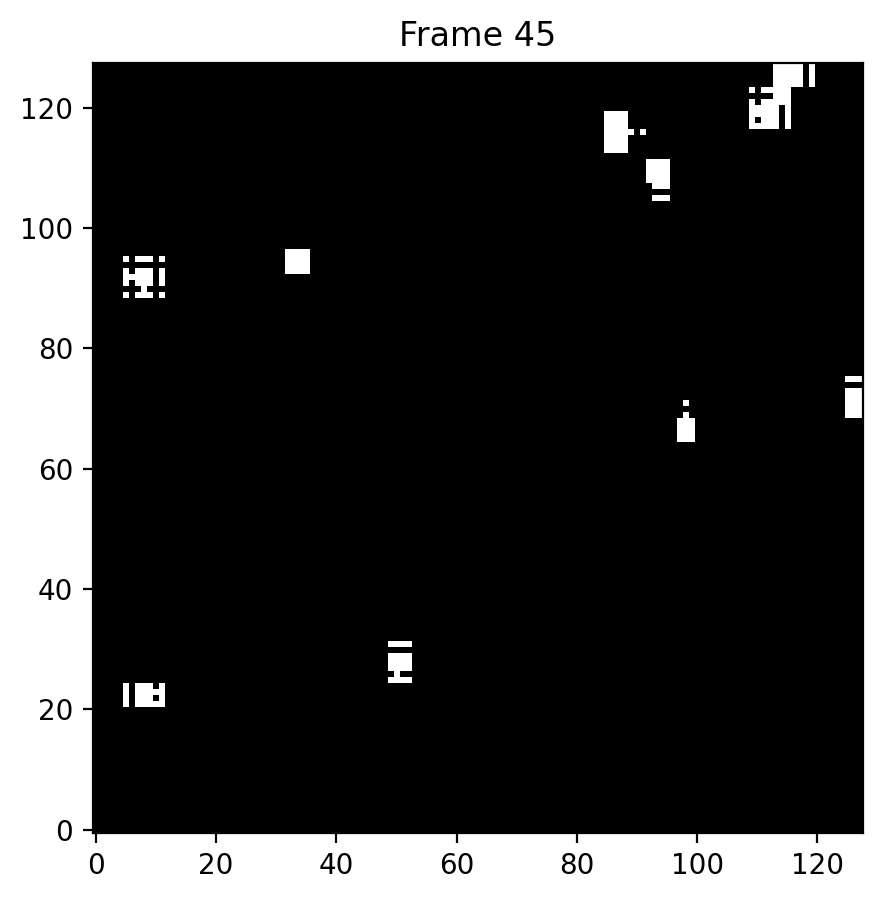

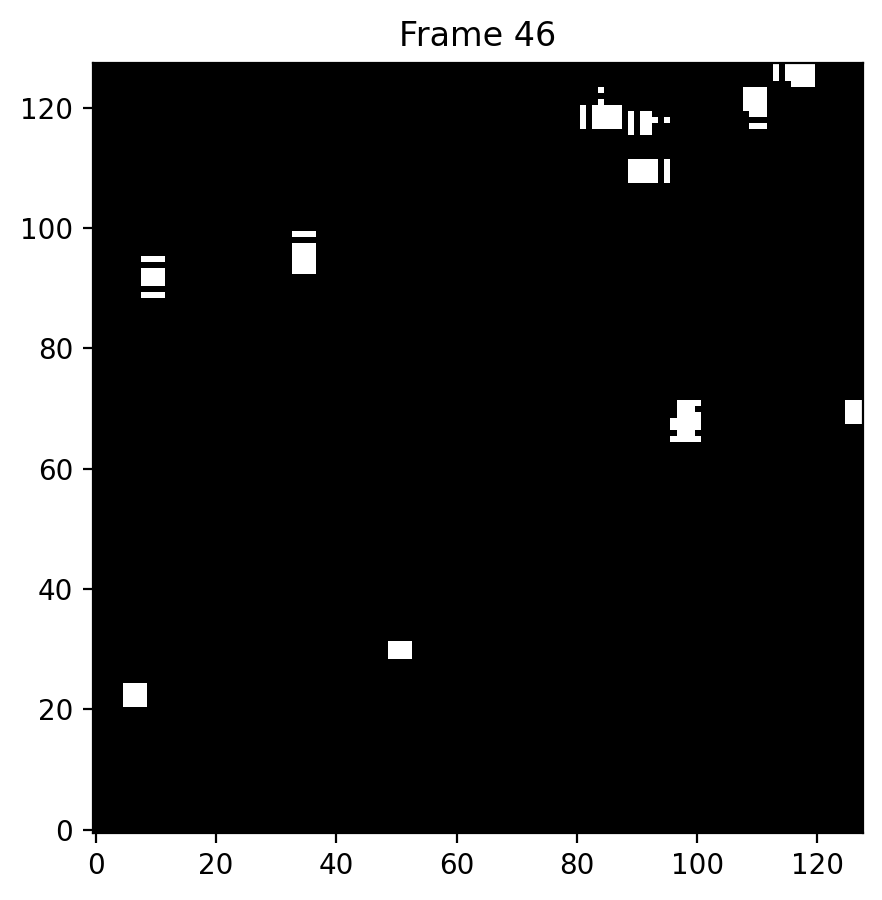

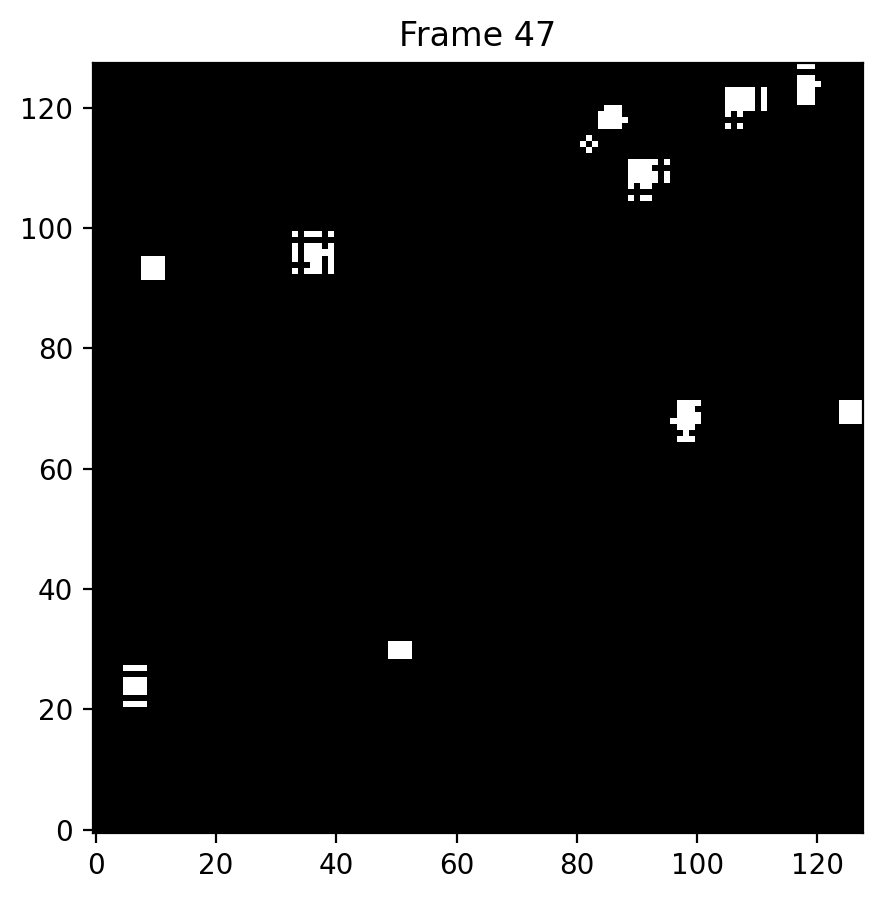

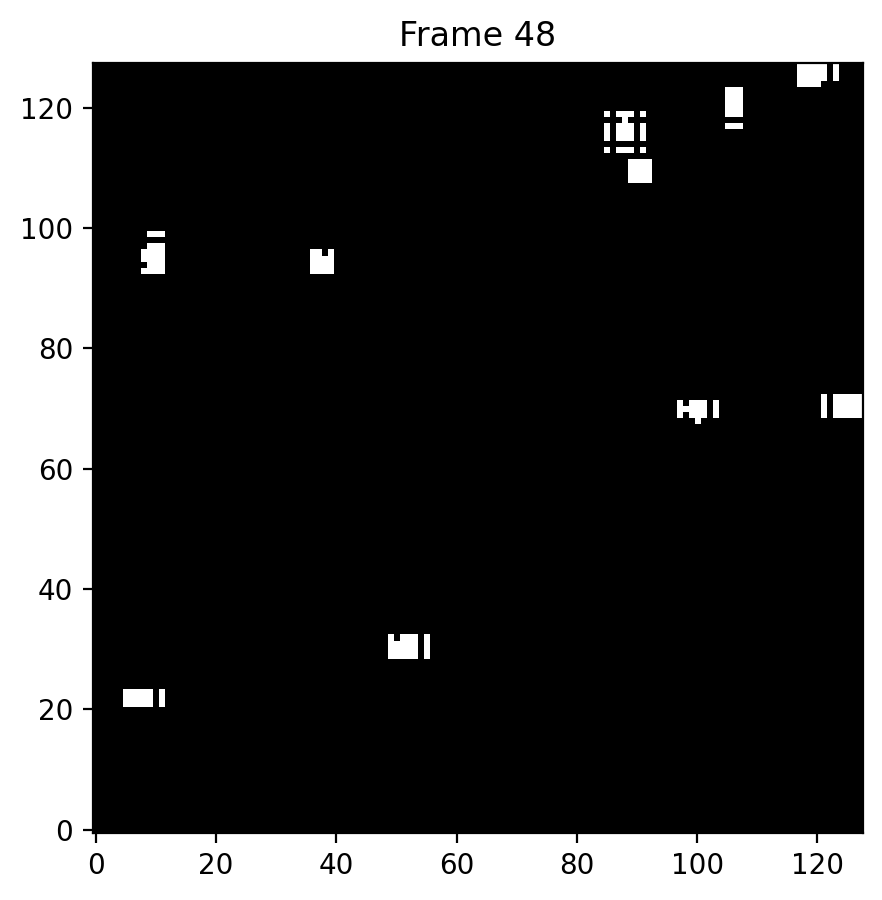

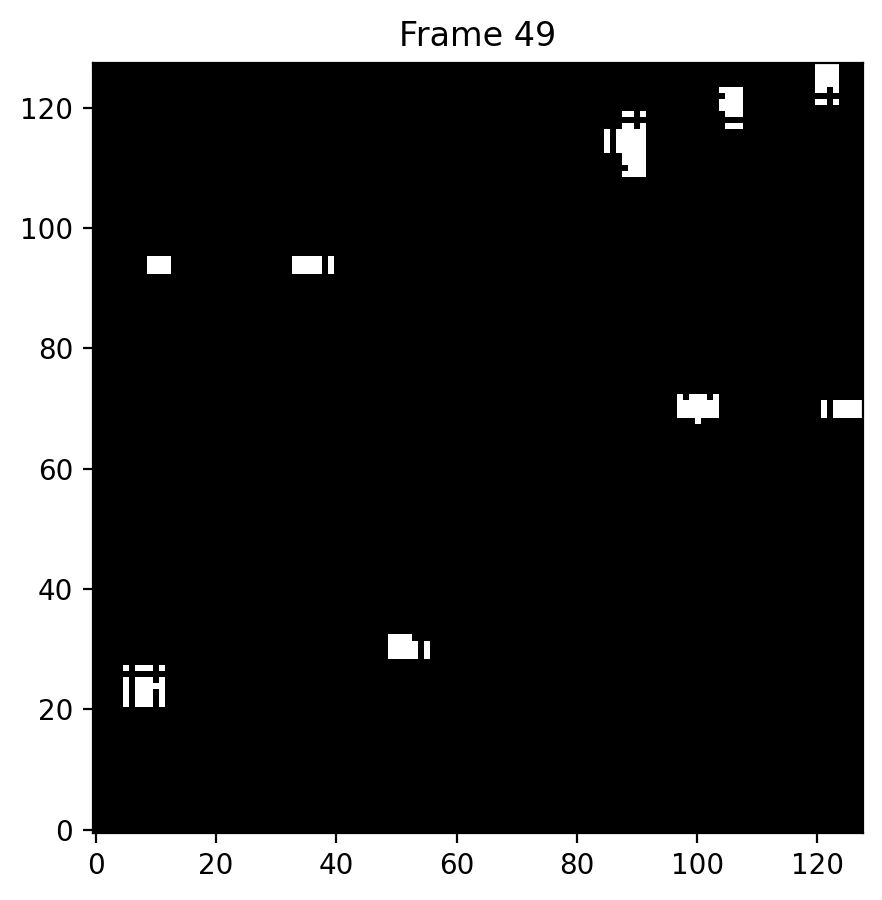

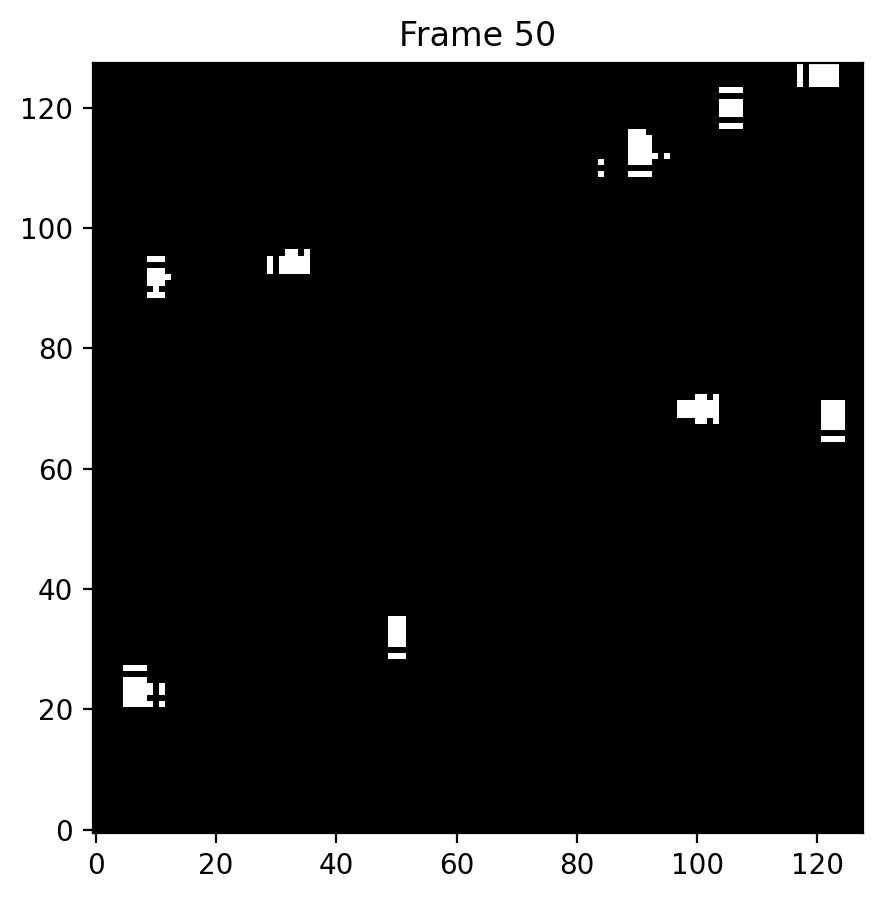

In [25]:
# Use our model
predictions = model.predict(test_vid)

# Label the particle
predicted_labels = predictions[..., 1] > 0.5

# Storage the position of particle
particle_positions_per_frame = []

# Go through every frame
for i in range(predicted_labels.shape[0]):

    particle_positions = np.where(predicted_labels[i])

    particle_positions_per_frame.append(particle_positions)

    plt.figure(figsize=(5, 5))
    plt.imshow(predicted_labels[i], cmap='gray', origin='lower')
    plt.title(f"Frame {i+1}")
    plt.show()